# BERT BASELINE MODEL (ROBERTA TAGALOG BASE)

In [ ]:
# 1. SETUP AND INSTALLATION


!pip install transformers datasets accelerate ray[tune] optuna -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.3/108.3 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.4/71.4 MB 10.5 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: click
    Found existing installation: click 8.3.0
    Uninstalling click-8.3.0:
      Successfully uninstalled click-8.3.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0


In [ ]:

import os
import torch
import numpy as np
import pandas as pd
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    set_seed,
)
import optuna
from transformers import TrainerCallback
from google.colab import drive

# ---------------- SET SEED ----------------
set_seed(42)

# ---------------- MOUNT DRIVE ----------------
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
# ---------------- GPU CHECK ----------------
print("Checking GPU availability...")
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"✓ Using GPU: {torch.cuda.get_device_name(0)}")
    torch.cuda.empty_cache()
else:
    device = torch.device("cpu")
    print("⚠ GPU not available. Using CPU.")

Checking GPU availability...
✓ Using GPU: Tesla T4


In [ ]:

# ---------------- Loading and Preprocessing Data ----------------
print("\n--- Loading and Preprocessing Data ---")
csv_path = '/content/drive/MyDrive/datasets/proj dataset/dpwh_finetune2.csv'
df = pd.read_csv(csv_path)

print(f"✓ Loaded dataset with {len(df)} records")
print(f"Columns: {df.columns.tolist()}")
print("\nFirst few rows:")
print(df.head())

# Drop rows that contain "https" in the text (spam)
before_count = len(df)
df = df[~df['text'].str.contains('https', case=False, na=False)].reset_index(drop=True)
dropped = before_count - len(df)
print(f"✓ Dropped {dropped} rows containing 'https' (spam). New dataset size: {len(df)}")

# Check Sentiment distribution and map labels
print("\nSentiment distribution:")
print(df['Sentiment'].value_counts().sort_index())

label2id = {"Negative": 0, "Positive": 1}
id2label = {v: k for k, v in label2id.items()}
df["labels"] = df["Sentiment"].map(label2id)

# Train / Eval split (80/20). Avoid stratify if only one class remains.
stratify_col = df["Sentiment"] if df["Sentiment"].nunique() > 1 else None
if stratify_col is None:
    print("Warning: only one sentiment class present after preprocessing — not stratifying split.")

train_df, eval_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=stratify_col
)

print(f"\n✓ Train set: {len(train_df)} records")
print(f"✓ Eval set: {len(eval_df)} records")

train_data = Dataset.from_pandas(train_df[["text", "labels"]].reset_index(drop=True))
eval_data = Dataset.from_pandas(eval_df[["text", "labels"]].reset_index(drop=True))


--- Loading and Preprocessing Data ---
✓ Loaded dataset with 10262 records
Columns: ['text', 'Sentiment']

First few rows:
                                                text Sentiment
0   Galing mang baliktad ni Marcoleta mantalang n...  Negative
1  Netizens were asking how Escudero was able to ...  Negative
2  Netizens were asking how Escudero was able to ...  Negative
3  The Civil Aviation Authority of the Philippine...  Negative
4  Espinas of Biliran face Plunder Raps over P1B ...  Negative
✓ Dropped 4192 rows containing 'https' (spam). New dataset size: 6070

Sentiment distribution:
Sentiment
Negative    4908
Positive    1162
Name: count, dtype: int64

✓ Train set: 4856 records
✓ Eval set: 1214 records


In [ ]:

# ---------------- Tokenizer and Tokenization ----------------
MODEL_NAME = "jcblaise/roberta-tagalog-base"
print(f"\nLoading tokenizer: {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_function(examples):
    # keep your max_length and padding settings
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

print("Tokenizing training data...")
tokenized_train = train_data.map(tokenize_function, batched=True)
print("Tokenizing evaluation data...")
tokenized_eval = eval_data.map(tokenize_function, batched=True)

tokenized_train.set_format("torch", columns=['input_ids', 'attention_mask', 'labels'])
tokenized_eval.set_format("torch", columns=['input_ids', 'attention_mask', 'labels'])



Loading tokenizer: jcblaise/roberta-tagalog-base


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

Tokenizing training data...


Map:   0%|          | 0/4856 [00:00<?, ? examples/s]

Tokenizing evaluation data...


Map:   0%|          | 0/1214 [00:00<?, ? examples/s]

In [ ]:

# --- 3. MODEL, METRICS, AND HYPERPARAMETER DEFINITION ---

# Function to initialize a fresh model for each random search run
def model_init():
    # Model must be re-initialized for every run to ensure independence
    return AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=4).to(device)

def compute_metrics(p):
    # Uses weighted F1-Score as the primary metric for 4-class classification
    preds = np.argmax(p.predictions, axis=1)
    acc = accuracy_score(p.label_ids, preds)
    f1 = f1_score(p.label_ids, preds, average="weighted")
    return {"accuracy": acc, "f1": f1}


In [ ]:

# --- HYPERPARAMETER RANDOM SEARCH SECTION ---
def tune_hp(trial):
    """
    This function defines the hyperparameter space to be explored using Random Search.
    The `trial` object allows us to suggest different values randomly.
    """

    learning_rate = trial.suggest_float("learning_rate", 5e-6, 5e-5, log=True)
    per_device_train_batch_size = trial.suggest_categorical("per_device_train_batch_size", [8, 16, 32])
    weight_decay = trial.suggest_float("weight_decay", 0.0, 0.1)
    num_train_epochs = trial.suggest_int("num_train_epochs", 3, 4)
    warmup_ratio = trial.suggest_float("warmup_ratio", 0.0, 0.2)
    lr_scheduler_type = trial.suggest_categorical("lr_scheduler_type", ["linear", "cosine", "constant_with_warmup"])
    gradient_accumulation_steps = trial.suggest_categorical("gradient_accumulation_steps", [1, 2, 4])
    max_grad_norm = trial.suggest_float("max_grad_norm", 0.5, 2.0)

    return {
        "learning_rate": learning_rate,
        "per_device_train_batch_size": per_device_train_batch_size,
        "weight_decay": weight_decay,
        "num_train_epochs": num_train_epochs,
        "warmup_ratio": warmup_ratio,
        "lr_scheduler_type": lr_scheduler_type,
        "gradient_accumulation_steps": gradient_accumulation_steps,
        "max_grad_norm": max_grad_norm,
    }


In [ ]:

# --- 4. TRAINING ARGUMENTS (Fixed for all runs) ---
# Most arguments are fixed, only the hyperparameters in tune_hp vary per run.
training_args = TrainingArguments(
    output_dir="./random_search_results",
    # Evaluation settings (fixed)
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1", # Optimize for weighted F1-Score
    fp16=torch.cuda.is_available(),
    report_to="none",
    # Fixed parameters
    warmup_steps=500,
)

# Initialize the Trainer
trainer = Trainer(
    model_init=model_init, # We pass the function, not the object, for fresh initialization
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

# Custom callback to show results after each trial
from transformers import TrainerCallback

class OptunaProgressCallback(TrainerCallback):
    """Callback to display trial results after evaluation"""
    def __init__(self):
        self.trial_num = 0

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        if metrics and state.is_world_process_zero:
            print(f"\n📊 Trial Results:")
            print(f"  • Eval F1 Score: {metrics.get('eval_f1', 0):.4f}")
            print(f"  • Eval Accuracy: {metrics.get('eval_accuracy', 0):.4f}")
            print(f"  • Eval Loss: {metrics.get('eval_loss', 0):.4f}")

# Add the callback to trainer
trainer.add_callback(OptunaProgressCallback())


/tmp/ipython-input-4248983770.py:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


config.json:   0%|          | 0.00/715 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/437M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at jcblaise/roberta-tagalog-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:

# --- 5. EXECUTION OF RANDOM SEARCH ---
# We use Optuna backend with Random Search (TPE sampler by default)
print("\n" + "="*80)
print("STARTING RANDOM SEARCH OPTIMIZATION")
print("="*80)
print("Total Trials: 30")
print("Optimization Metric: Weighted F1-Score")
print("="*80 + "\n")

# Create a custom callback to display hyperparameters for each trial
import optuna

def optuna_hp_space(trial):
    """Wrapper to display trial information"""
    print(f"\n{'='*80}")
    print(f"TRIAL #{trial.number + 1}")
    print(f"{'='*80}")

    # Get hyperparameters
    hps = tune_hp(trial)

    # Display the hyperparameters being tested
    print("Hyperparameters for this trial:")
    for key, value in hps.items():
        if isinstance(value, float):
            print(f"  • {key}: {value:.2e}" if value < 0.001 else f"  • {key}: {value:.4f}")
        else:
            print(f"  • {key}: {value}")
    print(f"{'='*80}")

    return hps

best_trial = trainer.hyperparameter_search(
    backend="optuna",
    hp_space=optuna_hp_space,
    direction="maximize",
    n_trials=20,
)

print("\n" + "="*80)
print("RANDOM SEARCH COMPLETE")
print("="*80)

# Extract and print the best configuration
if best_trial:
    print(f"\n✓ Best Trial Found!")
    print(f"✓ Best F1 Score: {best_trial.objective:.4f}")

    best_hps = best_trial.hyperparameters

    print("\n" + "="*80)
    print("BEST HYPERPARAMETERS")
    print("="*80)
    for key, value in best_hps.items():
        if isinstance(value, float):
            print(f"  • {key}: {value:.2e}" if value < 0.001 else f"  • {key}: {value:.4f}")
        else:
            print(f"  • {key}: {value}")
    print("="*80)

    # Show comparison with default values
    print("\n📊 Performance Summary:")
    print(f"  Final Best F1 Score: {best_trial.objective:.4f}")
    print(f"  Final Best Accuracy: (check evaluation results above)")

else:
    print("⚠ Search failed or no best trial found.")

print("\n✓ To use these hyperparameters, create a new TrainingArguments with the best_hps values.")
print("="*80)

[I 2025-11-16 12:17:52,544] A new study created in memory with name: no-name-016fad59-f9a8-4146-91eb-b0b6680d2d58



STARTING RANDOM SEARCH OPTIMIZATION
Total Trials: 30
Optimization Metric: Weighted F1-Score


TRIAL #1
Hyperparameters for this trial:
  • learning_rate: 5.77e-06
  • per_device_train_batch_size: 8
  • weight_decay: 0.0709
  • num_train_epochs: 4
  • warmup_ratio: 0.0984
  • lr_scheduler_type: constant_with_warmup
  • gradient_accumulation_steps: 1
  • max_grad_norm: 1.7782


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at jcblaise/roberta-tagalog-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.697700,0.456642,0.810544,0.736062
2,0.452400,0.399640,0.853377,0.833029
3,0.339800,0.404308,0.841845,0.848040
4,0.273200,0.522709,0.861614,0.866538



📊 Trial Results:
  • Eval F1 Score: 0.7361
  • Eval Accuracy: 0.8105
  • Eval Loss: 0.4566

📊 Trial Results:
  • Eval F1 Score: 0.8330
  • Eval Accuracy: 0.8534
  • Eval Loss: 0.3996

📊 Trial Results:
  • Eval F1 Score: 0.8480
  • Eval Accuracy: 0.8418
  • Eval Loss: 0.4043

📊 Trial Results:
  • Eval F1 Score: 0.8665
  • Eval Accuracy: 0.8616
  • Eval Loss: 0.5227


[I 2025-11-16 12:22:22,879] Trial 0 finished with value: 1.728152264298937 and parameters: {'learning_rate': 5.7745969064871305e-06, 'per_device_train_batch_size': 8, 'weight_decay': 0.07089951607045124, 'num_train_epochs': 4, 'warmup_ratio': 0.09841505999539718, 'lr_scheduler_type': 'constant_with_warmup', 'gradient_accumulation_steps': 1, 'max_grad_norm': 1.7781932256196589}. Best is trial 0 with value: 1.728152264298937.



TRIAL #2
Hyperparameters for this trial:
  • learning_rate: 2.49e-05
  • per_device_train_batch_size: 8
  • weight_decay: 0.0689
  • num_train_epochs: 3
  • warmup_ratio: 0.0530
  • lr_scheduler_type: linear
  • gradient_accumulation_steps: 4
  • max_grad_norm: 1.5614


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at jcblaise/roberta-tagalog-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.478032,0.808896,0.723439
2,No log,0.398724,0.836079,0.812491
3,No log,0.331521,0.884679,0.871980



📊 Trial Results:
  • Eval F1 Score: 0.7234
  • Eval Accuracy: 0.8089
  • Eval Loss: 0.4780

📊 Trial Results:
  • Eval F1 Score: 0.8125
  • Eval Accuracy: 0.8361
  • Eval Loss: 0.3987

📊 Trial Results:
  • Eval F1 Score: 0.8720
  • Eval Accuracy: 0.8847
  • Eval Loss: 0.3315


[I 2025-11-16 12:25:21,650] Trial 1 finished with value: 1.7566587295884635 and parameters: {'learning_rate': 2.489545197316624e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.06885596758994446, 'num_train_epochs': 3, 'warmup_ratio': 0.052963795384700335, 'lr_scheduler_type': 'linear', 'gradient_accumulation_steps': 4, 'max_grad_norm': 1.5614162769541924}. Best is trial 1 with value: 1.7566587295884635.



TRIAL #3
Hyperparameters for this trial:
  • learning_rate: 1.62e-05
  • per_device_train_batch_size: 32
  • weight_decay: 0.0402
  • num_train_epochs: 3
  • warmup_ratio: 0.0731
  • lr_scheduler_type: constant_with_warmup
  • gradient_accumulation_steps: 2
  • max_grad_norm: 1.8269


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at jcblaise/roberta-tagalog-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.625456,0.808896,0.723439
2,No log,0.480179,0.808896,0.723439
3,No log,0.459041,0.809720,0.725409



📊 Trial Results:
  • Eval F1 Score: 0.7234
  • Eval Accuracy: 0.8089
  • Eval Loss: 0.6255

📊 Trial Results:
  • Eval F1 Score: 0.7234
  • Eval Accuracy: 0.8089
  • Eval Loss: 0.4802

📊 Trial Results:
  • Eval F1 Score: 0.7254
  • Eval Accuracy: 0.8097
  • Eval Loss: 0.4590


[I 2025-11-16 12:27:51,662] Trial 2 finished with value: 1.5351289469470766 and parameters: {'learning_rate': 1.6244280587230095e-05, 'per_device_train_batch_size': 32, 'weight_decay': 0.040230214076592344, 'num_train_epochs': 3, 'warmup_ratio': 0.0731431184815015, 'lr_scheduler_type': 'constant_with_warmup', 'gradient_accumulation_steps': 2, 'max_grad_norm': 1.8268929100422828}. Best is trial 1 with value: 1.7566587295884635.



TRIAL #4
Hyperparameters for this trial:
  • learning_rate: 1.00e-05
  • per_device_train_batch_size: 8
  • weight_decay: 0.0982
  • num_train_epochs: 3
  • warmup_ratio: 0.1897
  • lr_scheduler_type: constant_with_warmup
  • gradient_accumulation_steps: 2
  • max_grad_norm: 1.6702


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at jcblaise/roberta-tagalog-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.468433,0.808896,0.723439
2,0.625800,0.376291,0.850906,0.831453
3,0.625800,0.317995,0.873970,0.872343



📊 Trial Results:
  • Eval F1 Score: 0.7234
  • Eval Accuracy: 0.8089
  • Eval Loss: 0.4684

📊 Trial Results:
  • Eval F1 Score: 0.8315
  • Eval Accuracy: 0.8509
  • Eval Loss: 0.3763

📊 Trial Results:
  • Eval F1 Score: 0.8723
  • Eval Accuracy: 0.8740
  • Eval Loss: 0.3180


[I 2025-11-16 12:30:58,323] Trial 3 finished with value: 1.7463131458112584 and parameters: {'learning_rate': 1.0014445207136754e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.09822025799757611, 'num_train_epochs': 3, 'warmup_ratio': 0.18970394604632462, 'lr_scheduler_type': 'constant_with_warmup', 'gradient_accumulation_steps': 2, 'max_grad_norm': 1.670168297189011}. Best is trial 1 with value: 1.7566587295884635.



TRIAL #5
Hyperparameters for this trial:
  • learning_rate: 1.87e-05
  • per_device_train_batch_size: 8
  • weight_decay: 0.0128
  • num_train_epochs: 3
  • warmup_ratio: 0.1507
  • lr_scheduler_type: linear
  • gradient_accumulation_steps: 1
  • max_grad_norm: 1.1090


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at jcblaise/roberta-tagalog-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.606300,0.403723,0.844316,0.842306
2,0.356500,0.361280,0.878089,0.868420
3,0.247500,0.464633,0.885502,0.884829



📊 Trial Results:
  • Eval F1 Score: 0.8423
  • Eval Accuracy: 0.8443
  • Eval Loss: 0.4037

📊 Trial Results:
  • Eval F1 Score: 0.8684
  • Eval Accuracy: 0.8781
  • Eval Loss: 0.3613

📊 Trial Results:
  • Eval F1 Score: 0.8848
  • Eval Accuracy: 0.8855
  • Eval Loss: 0.4646


[I 2025-11-16 12:34:42,834] Trial 4 finished with value: 1.7703313654023742 and parameters: {'learning_rate': 1.8682525577713768e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.01284524801588517, 'num_train_epochs': 3, 'warmup_ratio': 0.15069246399540415, 'lr_scheduler_type': 'linear', 'gradient_accumulation_steps': 1, 'max_grad_norm': 1.1090162842346456}. Best is trial 4 with value: 1.7703313654023742.



TRIAL #6
Hyperparameters for this trial:
  • learning_rate: 6.18e-06
  • per_device_train_batch_size: 16
  • weight_decay: 0.0907
  • num_train_epochs: 4
  • warmup_ratio: 0.1173
  • lr_scheduler_type: cosine
  • gradient_accumulation_steps: 2
  • max_grad_norm: 1.3231


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at jcblaise/roberta-tagalog-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.551217,0.808896,0.723439
2,No log,0.478440,0.808896,0.723439



📊 Trial Results:
  • Eval F1 Score: 0.7234
  • Eval Accuracy: 0.8089
  • Eval Loss: 0.5512

📊 Trial Results:
  • Eval F1 Score: 0.7234
  • Eval Accuracy: 0.8089
  • Eval Loss: 0.4784


[I 2025-11-16 12:36:11,256] Trial 5 pruned. 



TRIAL #7
Hyperparameters for this trial:
  • learning_rate: 1.37e-05
  • per_device_train_batch_size: 8
  • weight_decay: 0.0110
  • num_train_epochs: 4
  • warmup_ratio: 0.1229
  • lr_scheduler_type: constant_with_warmup
  • gradient_accumulation_steps: 2
  • max_grad_norm: 1.3432


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at jcblaise/roberta-tagalog-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.459387,0.810544,0.727365



📊 Trial Results:
  • Eval F1 Score: 0.7274
  • Eval Accuracy: 0.8105
  • Eval Loss: 0.4594


[I 2025-11-16 12:36:55,584] Trial 6 pruned. 



TRIAL #8
Hyperparameters for this trial:
  • learning_rate: 1.85e-05
  • per_device_train_batch_size: 16
  • weight_decay: 0.0818
  • num_train_epochs: 3
  • warmup_ratio: 0.1514
  • lr_scheduler_type: constant_with_warmup
  • gradient_accumulation_steps: 2
  • max_grad_norm: 0.7541


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at jcblaise/roberta-tagalog-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.483304,0.808896,0.723439
2,No log,0.447718,0.811367,0.733713



📊 Trial Results:
  • Eval F1 Score: 0.7234
  • Eval Accuracy: 0.8089
  • Eval Loss: 0.4833

📊 Trial Results:
  • Eval F1 Score: 0.7337
  • Eval Accuracy: 0.8114
  • Eval Loss: 0.4477


[I 2025-11-16 12:38:22,279] Trial 7 pruned. 



TRIAL #9
Hyperparameters for this trial:
  • learning_rate: 4.26e-05
  • per_device_train_batch_size: 8
  • weight_decay: 0.0628
  • num_train_epochs: 4
  • warmup_ratio: 0.1050
  • lr_scheduler_type: constant_with_warmup
  • gradient_accumulation_steps: 2
  • max_grad_norm: 1.5902


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at jcblaise/roberta-tagalog-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.401589,0.837727,0.830478
2,0.507500,0.310769,0.877265,0.867046
3,0.507500,0.376855,0.881384,0.882695
4,0.216700,0.497520,0.864909,0.870041



📊 Trial Results:
  • Eval F1 Score: 0.8305
  • Eval Accuracy: 0.8377
  • Eval Loss: 0.4016

📊 Trial Results:
  • Eval F1 Score: 0.8670
  • Eval Accuracy: 0.8773
  • Eval Loss: 0.3108

📊 Trial Results:
  • Eval F1 Score: 0.8827
  • Eval Accuracy: 0.8814
  • Eval Loss: 0.3769

📊 Trial Results:
  • Eval F1 Score: 0.8700
  • Eval Accuracy: 0.8649
  • Eval Loss: 0.4975


[I 2025-11-16 12:43:04,208] Trial 8 finished with value: 1.7349505254867652 and parameters: {'learning_rate': 4.262020323421047e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.06279215582373063, 'num_train_epochs': 4, 'warmup_ratio': 0.10497907909460086, 'lr_scheduler_type': 'constant_with_warmup', 'gradient_accumulation_steps': 2, 'max_grad_norm': 1.590188216690257}. Best is trial 4 with value: 1.7703313654023742.



TRIAL #10
Hyperparameters for this trial:
  • learning_rate: 5.47e-06
  • per_device_train_batch_size: 8
  • weight_decay: 0.0837
  • num_train_epochs: 4
  • warmup_ratio: 0.1855
  • lr_scheduler_type: constant_with_warmup
  • gradient_accumulation_steps: 2
  • max_grad_norm: 1.6659


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at jcblaise/roberta-tagalog-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.484890,0.808896,0.723439



📊 Trial Results:
  • Eval F1 Score: 0.7234
  • Eval Accuracy: 0.8089
  • Eval Loss: 0.4849


[I 2025-11-16 12:43:49,006] Trial 9 pruned. 



TRIAL #11
Hyperparameters for this trial:
  • learning_rate: 3.75e-05
  • per_device_train_batch_size: 32
  • weight_decay: 0.0021
  • num_train_epochs: 3
  • warmup_ratio: 0.0011
  • lr_scheduler_type: linear
  • gradient_accumulation_steps: 1
  • max_grad_norm: 0.8674


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at jcblaise/roberta-tagalog-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.466346,0.809720,0.725409
2,No log,0.367118,0.862438,0.860662
3,No log,0.296369,0.891269,0.884286



📊 Trial Results:
  • Eval F1 Score: 0.7254
  • Eval Accuracy: 0.8097
  • Eval Loss: 0.4663

📊 Trial Results:
  • Eval F1 Score: 0.8607
  • Eval Accuracy: 0.8624
  • Eval Loss: 0.3671

📊 Trial Results:
  • Eval F1 Score: 0.8843
  • Eval Accuracy: 0.8913
  • Eval Loss: 0.2964


[I 2025-11-16 12:47:04,232] Trial 10 finished with value: 1.7755542341323611 and parameters: {'learning_rate': 3.748285370991757e-05, 'per_device_train_batch_size': 32, 'weight_decay': 0.002065518680589365, 'num_train_epochs': 3, 'warmup_ratio': 0.0010773455926575692, 'lr_scheduler_type': 'linear', 'gradient_accumulation_steps': 1, 'max_grad_norm': 0.867437011786508}. Best is trial 10 with value: 1.7755542341323611.



TRIAL #12
Hyperparameters for this trial:
  • learning_rate: 4.23e-05
  • per_device_train_batch_size: 32
  • weight_decay: 0.0019
  • num_train_epochs: 3
  • warmup_ratio: 0.0096
  • lr_scheduler_type: linear
  • gradient_accumulation_steps: 1
  • max_grad_norm: 0.8022


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at jcblaise/roberta-tagalog-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.461988,0.811367,0.729308
2,No log,0.360701,0.861614,0.860441
3,No log,0.303374,0.892916,0.886039



📊 Trial Results:
  • Eval F1 Score: 0.7293
  • Eval Accuracy: 0.8114
  • Eval Loss: 0.4620

📊 Trial Results:
  • Eval F1 Score: 0.8604
  • Eval Accuracy: 0.8616
  • Eval Loss: 0.3607

📊 Trial Results:
  • Eval F1 Score: 0.8860
  • Eval Accuracy: 0.8929
  • Eval Loss: 0.3034


[I 2025-11-16 12:49:16,766] Trial 11 finished with value: 1.7789549275545982 and parameters: {'learning_rate': 4.229805188620375e-05, 'per_device_train_batch_size': 32, 'weight_decay': 0.0018992940815787023, 'num_train_epochs': 3, 'warmup_ratio': 0.00961616108744676, 'lr_scheduler_type': 'linear', 'gradient_accumulation_steps': 1, 'max_grad_norm': 0.8022008261683107}. Best is trial 11 with value: 1.7789549275545982.



TRIAL #13
Hyperparameters for this trial:
  • learning_rate: 4.65e-05
  • per_device_train_batch_size: 32
  • weight_decay: 8.66e-04
  • num_train_epochs: 3
  • warmup_ratio: 0.0068
  • lr_scheduler_type: linear
  • gradient_accumulation_steps: 1
  • max_grad_norm: 0.5325


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at jcblaise/roberta-tagalog-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.458940,0.811367,0.730802
2,No log,0.350138,0.869852,0.869418
3,No log,0.298052,0.893740,0.885995



📊 Trial Results:
  • Eval F1 Score: 0.7308
  • Eval Accuracy: 0.8114
  • Eval Loss: 0.4589

📊 Trial Results:
  • Eval F1 Score: 0.8694
  • Eval Accuracy: 0.8699
  • Eval Loss: 0.3501

📊 Trial Results:
  • Eval F1 Score: 0.8860
  • Eval Accuracy: 0.8937
  • Eval Loss: 0.2981


[I 2025-11-16 12:52:45,216] Trial 12 finished with value: 1.7797345113629683 and parameters: {'learning_rate': 4.6457537699788976e-05, 'per_device_train_batch_size': 32, 'weight_decay': 0.0008662963232594354, 'num_train_epochs': 3, 'warmup_ratio': 0.006828042983533317, 'lr_scheduler_type': 'linear', 'gradient_accumulation_steps': 1, 'max_grad_norm': 0.5324953621722768}. Best is trial 12 with value: 1.7797345113629683.



TRIAL #14
Hyperparameters for this trial:
  • learning_rate: 4.87e-05
  • per_device_train_batch_size: 32
  • weight_decay: 0.0291
  • num_train_epochs: 3
  • warmup_ratio: 9.38e-04
  • lr_scheduler_type: linear
  • gradient_accumulation_steps: 1
  • max_grad_norm: 0.5463


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at jcblaise/roberta-tagalog-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.457423,0.811367,0.732270
2,No log,0.352034,0.862438,0.864269
3,No log,0.299457,0.895387,0.886953



📊 Trial Results:
  • Eval F1 Score: 0.7323
  • Eval Accuracy: 0.8114
  • Eval Loss: 0.4574

📊 Trial Results:
  • Eval F1 Score: 0.8643
  • Eval Accuracy: 0.8624
  • Eval Loss: 0.3520

📊 Trial Results:
  • Eval F1 Score: 0.8870
  • Eval Accuracy: 0.8954
  • Eval Loss: 0.2995


[I 2025-11-16 12:55:48,989] Trial 13 finished with value: 1.7823404221312933 and parameters: {'learning_rate': 4.874314935099489e-05, 'per_device_train_batch_size': 32, 'weight_decay': 0.029103601328763058, 'num_train_epochs': 3, 'warmup_ratio': 0.0009375167125712236, 'lr_scheduler_type': 'linear', 'gradient_accumulation_steps': 1, 'max_grad_norm': 0.5462855211600564}. Best is trial 13 with value: 1.7823404221312933.



TRIAL #15
Hyperparameters for this trial:
  • learning_rate: 2.87e-05
  • per_device_train_batch_size: 32
  • weight_decay: 0.0326
  • num_train_epochs: 3
  • warmup_ratio: 0.0344
  • lr_scheduler_type: linear
  • gradient_accumulation_steps: 1
  • max_grad_norm: 0.5532


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at jcblaise/roberta-tagalog-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.474695,0.808896,0.723439



📊 Trial Results:
  • Eval F1 Score: 0.7234
  • Eval Accuracy: 0.8089
  • Eval Loss: 0.4747


[I 2025-11-16 12:56:21,586] Trial 14 pruned. 



TRIAL #16
Hyperparameters for this trial:
  • learning_rate: 4.72e-05
  • per_device_train_batch_size: 32
  • weight_decay: 0.0259
  • num_train_epochs: 3
  • warmup_ratio: 0.0332
  • lr_scheduler_type: cosine
  • gradient_accumulation_steps: 4
  • max_grad_norm: 0.5364


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at jcblaise/roberta-tagalog-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.725783,0.808896,0.723439
2,No log,0.487465,0.808896,0.723439
3,No log,0.489868,0.808896,0.723439



📊 Trial Results:
  • Eval F1 Score: 0.7234
  • Eval Accuracy: 0.8089
  • Eval Loss: 0.7258

📊 Trial Results:
  • Eval F1 Score: 0.7234
  • Eval Accuracy: 0.8089
  • Eval Loss: 0.4875

📊 Trial Results:
  • Eval F1 Score: 0.7234
  • Eval Accuracy: 0.8089
  • Eval Loss: 0.4899


[I 2025-11-16 12:59:16,466] Trial 15 finished with value: 1.532335262856234 and parameters: {'learning_rate': 4.7234951578263013e-05, 'per_device_train_batch_size': 32, 'weight_decay': 0.025857952266185535, 'num_train_epochs': 3, 'warmup_ratio': 0.033223806545300674, 'lr_scheduler_type': 'cosine', 'gradient_accumulation_steps': 4, 'max_grad_norm': 0.5364446680504317}. Best is trial 13 with value: 1.7823404221312933.



TRIAL #17
Hyperparameters for this trial:
  • learning_rate: 2.94e-05
  • per_device_train_batch_size: 32
  • weight_decay: 0.0528
  • num_train_epochs: 3
  • warmup_ratio: 0.0246
  • lr_scheduler_type: linear
  • gradient_accumulation_steps: 1
  • max_grad_norm: 0.9228


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at jcblaise/roberta-tagalog-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.474221,0.808896,0.723439



📊 Trial Results:
  • Eval F1 Score: 0.7234
  • Eval Accuracy: 0.8089
  • Eval Loss: 0.4742


[I 2025-11-16 12:59:49,166] Trial 16 pruned. 



TRIAL #18
Hyperparameters for this trial:
  • learning_rate: 3.46e-05
  • per_device_train_batch_size: 32
  • weight_decay: 0.0213
  • num_train_epochs: 3
  • warmup_ratio: 0.0642
  • lr_scheduler_type: linear
  • gradient_accumulation_steps: 1
  • max_grad_norm: 1.0749


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at jcblaise/roberta-tagalog-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.469374,0.808896,0.723439



📊 Trial Results:
  • Eval F1 Score: 0.7234
  • Eval Accuracy: 0.8089
  • Eval Loss: 0.4694


[I 2025-11-16 13:00:21,719] Trial 17 pruned. 



TRIAL #19
Hyperparameters for this trial:
  • learning_rate: 2.43e-05
  • per_device_train_batch_size: 32
  • weight_decay: 0.0369
  • num_train_epochs: 3
  • warmup_ratio: 4.70e-04
  • lr_scheduler_type: linear
  • gradient_accumulation_steps: 1
  • max_grad_norm: 0.6565


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at jcblaise/roberta-tagalog-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.477582,0.808896,0.723439



📊 Trial Results:
  • Eval F1 Score: 0.7234
  • Eval Accuracy: 0.8089
  • Eval Loss: 0.4776


[I 2025-11-16 13:00:54,074] Trial 18 pruned. 



TRIAL #20
Hyperparameters for this trial:
  • learning_rate: 1.01e-05
  • per_device_train_batch_size: 16
  • weight_decay: 0.0457
  • num_train_epochs: 3
  • warmup_ratio: 0.0518
  • lr_scheduler_type: cosine
  • gradient_accumulation_steps: 4
  • max_grad_norm: 0.6516


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at jcblaise/roberta-tagalog-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.781503,0.808896,0.723439
2,No log,0.495703,0.808896,0.723439



📊 Trial Results:
  • Eval F1 Score: 0.7234
  • Eval Accuracy: 0.8089
  • Eval Loss: 0.7815

📊 Trial Results:
  • Eval F1 Score: 0.7234
  • Eval Accuracy: 0.8089
  • Eval Loss: 0.4957


[I 2025-11-16 13:02:22,057] Trial 19 pruned. 



RANDOM SEARCH COMPLETE

✓ Best Trial Found!
✓ Best F1 Score: 1.7823

BEST HYPERPARAMETERS
  • learning_rate: 4.87e-05
  • per_device_train_batch_size: 32
  • weight_decay: 0.0291
  • num_train_epochs: 3
  • warmup_ratio: 9.38e-04
  • lr_scheduler_type: linear
  • gradient_accumulation_steps: 1
  • max_grad_norm: 0.5463

📊 Performance Summary:
  Final Best F1 Score: 1.7823
  Final Best Accuracy: (check evaluation results above)

✓ To use these hyperparameters, create a new TrainingArguments with the best_hps values.


# BERT ( mapsoriano/Roberta-tagalog-Hatespeech)

The BERT model is already pretrained from a large sentiment-hatespeech analysis consisting of twitter-based opinions on philipine elections from 2016 to 2022, we will fine tune our dataset to this already fine tuned model.

In [1]:
!pip install transformers datasets accelerate optuna scikit-learn matplotlib seaborn -U


In [7]:

import os
import torch
import numpy as np
import pandas as pd
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    set_seed,
)
import optuna
from transformers import TrainerCallback
from google.colab import drive

# ---------------- SET SEED ----------------
set_seed(42)

# ---------------- MOUNT DRIVE ----------------
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:

# ---------------- GPU CHECK ----------------
print("Checking GPU availability...")
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"✓ Using GPU: {torch.cuda.get_device_name(0)}")
    torch.cuda.empty_cache()
else:
    device = torch.device("cpu")
    print("⚠ GPU not available. Using CPU.")



Checking GPU availability...
✓ Using GPU: Tesla T4


In [9]:

# ---------------- Loading and Preprocessing Data ----------------
print("\n--- Loading and Preprocessing Data ---")
csv_path = '/content/drive/MyDrive/datasets/proj dataset/dpwh_finetune2.csv'
df = pd.read_csv(csv_path)

print(f"✓ Loaded dataset with {len(df)} records")
print(f"Columns: {df.columns.tolist()}")
print("\nFirst few rows:")
print(df.head())

# Drop rows that contain "https" in the text (spam)
before_count = len(df)
df = df[~df['text'].str.contains('https', case=False, na=False)].reset_index(drop=True)
dropped = before_count - len(df)
print(f"✓ Dropped {dropped} rows containing 'https' (spam). New dataset size: {len(df)}")

# Check Sentiment distribution and map labels
print("\nSentiment distribution:")
print(df['Sentiment'].value_counts().sort_index())

label2id = {"Negative": 0, "Positive": 1}
id2label = {v: k for k, v in label2id.items()}
df["labels"] = df["Sentiment"].map(label2id)

# Train / Eval split (80/20). Avoid stratify if only one class remains.
stratify_col = df["Sentiment"] if df["Sentiment"].nunique() > 1 else None
if stratify_col is None:
    print("Warning: only one sentiment class present after preprocessing — not stratifying split.")

train_df, eval_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=stratify_col
)

print(f"\n✓ Train set: {len(train_df)} records")
print(f"✓ Eval set: {len(eval_df)} records")

train_data = Dataset.from_pandas(train_df[["text", "labels"]].reset_index(drop=True))
eval_data = Dataset.from_pandas(eval_df[["text", "labels"]].reset_index(drop=True))


--- Loading and Preprocessing Data ---
✓ Loaded dataset with 10262 records
Columns: ['text', 'Sentiment']

First few rows:
                                                text Sentiment
0   Galing mang baliktad ni Marcoleta mantalang n...  Negative
1  Netizens were asking how Escudero was able to ...  Negative
2  Netizens were asking how Escudero was able to ...  Negative
3  The Civil Aviation Authority of the Philippine...  Negative
4  Espinas of Biliran face Plunder Raps over P1B ...  Negative
✓ Dropped 4192 rows containing 'https' (spam). New dataset size: 6070

Sentiment distribution:
Sentiment
Negative    4908
Positive    1162
Name: count, dtype: int64

✓ Train set: 4856 records
✓ Eval set: 1214 records


In [10]:

# ---------------- Tokenizer and Tokenization ----------------
MODEL_NAME = "mapsoriano/roberta-tagalog-base-philippine-elections-2016-2022-hate-speech"
print(f"\nLoading tokenizer: {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_function(examples):
    # keep your max_length and padding settings
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

print("Tokenizing training data...")
tokenized_train = train_data.map(tokenize_function, batched=True)
print("Tokenizing evaluation data...")
tokenized_eval = eval_data.map(tokenize_function, batched=True)

tokenized_train.set_format("torch", columns=['input_ids', 'attention_mask', 'labels'])
tokenized_eval.set_format("torch", columns=['input_ids', 'attention_mask', 'labels'])




Loading tokenizer: mapsoriano/roberta-tagalog-base-philippine-elections-2016-2022-hate-speech


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/957 [00:00<?, ?B/s]

Tokenizing training data...


Map:   0%|          | 0/4856 [00:00<?, ? examples/s]

Tokenizing evaluation data...


Map:   0%|          | 0/1214 [00:00<?, ? examples/s]

In [11]:

# --- 3. MODEL, METRICS, AND HYPERPARAMETER DEFINITION ---

# Use the actual number of labels from our mapping
NUM_LABELS = len(label2id)

# Function to initialize a fresh model for each random search run
def model_init():
    # Model must be re-initialized for every run to ensure independence
    # Use the same MODEL_NAME but ensure num_labels matches our dataset
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS)
    # move to device for consistency (Trainer will also handle device placement)
    return model.to(device)

def compute_metrics(p):
    # Uses weighted F1-Score as the primary metric for classification
    preds = np.argmax(p.predictions, axis=1)
    acc = accuracy_score(p.label_ids, preds)
    f1 = f1_score(p.label_ids, preds, average="weighted")
    return {"accuracy": acc, "f1": f1}



In [12]:

# --- HYPERPARAMETER RANDOM SEARCH SECTION ---
def tune_hp(trial):
    """ This function defines the hyperparameter space to be explored using Random Search. """
    learning_rate = trial.suggest_float("learning_rate", 5e-6, 5e-5, log=True)
    per_device_train_batch_size = trial.suggest_categorical("per_device_train_batch_size", [8, 16, 32])
    weight_decay = trial.suggest_float("weight_decay", 0.0, 0.1)
    num_train_epochs = trial.suggest_int("num_train_epochs", 3, 4)
    warmup_ratio = trial.suggest_float("warmup_ratio", 0.0, 0.2)
    lr_scheduler_type = trial.suggest_categorical("lr_scheduler_type", ["linear", "cosine", "constant_with_warmup"])
    gradient_accumulation_steps = trial.suggest_categorical("gradient_accumulation_steps", [1, 2, 4])
    max_grad_norm = trial.suggest_float("max_grad_norm", 0.5, 2.0)
    return {
        "learning_rate": learning_rate,
        "per_device_train_batch_size": per_device_train_batch_size,
        "weight_decay": weight_decay,
        "num_train_epochs": num_train_epochs,
        "warmup_ratio": warmup_ratio,
        "lr_scheduler_type": lr_scheduler_type,
        "gradient_accumulation_steps": gradient_accumulation_steps,
        "max_grad_norm": max_grad_norm,
    }


In [13]:

# --- 4. TRAINING ARGUMENTS (Fixed for all runs) ---
training_args = TrainingArguments(
    output_dir="./random_search_results",
    # Evaluation settings (fixed)
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",  # Optimize for weighted F1-Score
    fp16=torch.cuda.is_available(),
    report_to="none",
    # Fixed parameters
    warmup_steps=500,
)

# Initialize the Trainer
trainer = Trainer(
    model_init=model_init,  # We pass the function, not the object, for fresh initialization
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

# Custom callback to show results after each trial
class OptunaProgressCallback(TrainerCallback):
    """Callback to display trial results after evaluation"""
    def __init__(self):
        self.trial_num = 0

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        if metrics and state.is_world_process_zero:
            print(f"\n📊 Trial Results:")
            print(f" • Eval F1 Score: {metrics.get('eval_f1', 0):.4f}")
            print(f" • Eval Accuracy: {metrics.get('eval_accuracy', 0):.4f}")
            print(f" • Eval Loss: {metrics.get('eval_loss', 0):.4f}")

# Add the callback to trainer
trainer.add_callback(OptunaProgressCallback())



/tmp/ipython-input-2480851252.py:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


config.json:   0%|          | 0.00/899 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [14]:

# --- 5. EXECUTION OF RANDOM SEARCH ---
print("\n" + "="*80)
print("STARTING RANDOM SEARCH OPTIMIZATION")
print("="*80)
print("Total Trials: 20")
print("Optimization Metric: Weighted F1-Score")
print("="*80 + "\n")

# Create a custom callback to display hyperparameters for each trial
def optuna_hp_space(trial):
    """Wrapper to display trial information"""
    print(f"\n{'='*80}")
    print(f"TRIAL #{trial.number + 1}")
    print(f"{'='*80}")
    # Get hyperparameters
    hps = tune_hp(trial)
    # Display the hyperparameters being tested
    print("Hyperparameters for this trial:")
    for key, value in hps.items():
        if isinstance(value, float):
            print(f" • {key}: {value:.2e}" if value < 0.001 else f" • {key}: {value:.4f}")
        else:
            print(f" • {key}: {value}")
    print(f"{'='*80}")
    return hps

# Run hyperparameter search (Optuna backend)
best_trial = trainer.hyperparameter_search(
    backend="optuna",
    hp_space=optuna_hp_space,
    direction="maximize",
    n_trials=20,
)

print("\n" + "="*80)
print("RANDOM SEARCH COMPLETE")
print("="*80)

# Extract and print the best configuration
if best_trial:
    print(f"\n✓ Best Trial Found!")
    # optuna integration returns an object: best_trial.objective and best_trial.hyperparameters
    try:
        print(f"✓ Best F1 Score: {best_trial.objective:.4f}")
    except Exception:
        # if the returned object is a dict-like or different structure, just print representation
        print("✓ Best trial summary:", best_trial)
    best_hps = getattr(best_trial, "hyperparameters", best_trial.params if hasattr(best_trial, "params") else None)
    print("\n" + "="*80)
    print("BEST HYPERPARAMETERS")
    print("="*80)
    if best_hps:
        for key, value in best_hps.items():
            if isinstance(value, float):
                print(f" • {key}: {value:.2e}" if value < 0.001 else f" • {key}: {value:.4f}")
            else:
                print(f" • {key}: {value}")
    else:
        print("Could not extract hyperparameters from best_trial object.")
    print("="*80)
    print("\n📊 Performance Summary:")
    try:
        print(f" Final Best F1 Score: {best_trial.objective:.4f}")
    except Exception:
        pass
    print(f" Final Best Accuracy: (Check evaluation results above)")
else:
    print("⚠ Search failed or no best trial found.")

print("\n✓ To use these hyperparameters, create a new TrainingArguments with the best_hps values.")
print("="*80)



[I 2025-11-16 14:47:44,903] A new study created in memory with name: no-name-518bf9fb-fbb5-4a1c-bab4-edfacba516e2



STARTING RANDOM SEARCH OPTIMIZATION
Total Trials: 20
Optimization Metric: Weighted F1-Score


TRIAL #1
Hyperparameters for this trial:
 • learning_rate: 2.70e-05
 • per_device_train_batch_size: 8
 • weight_decay: 0.0438
 • num_train_epochs: 4
 • warmup_ratio: 0.0559
 • lr_scheduler_type: linear
 • gradient_accumulation_steps: 4
 • max_grad_norm: 0.8488


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.473561,0.808896,0.724995
2,No log,0.415216,0.828666,0.786794
3,No log,0.377250,0.861614,0.840978
4,0.480900,0.405621,0.859143,0.856018



📊 Trial Results:
 • Eval F1 Score: 0.7250
 • Eval Accuracy: 0.8089
 • Eval Loss: 0.4736

📊 Trial Results:
 • Eval F1 Score: 0.7868
 • Eval Accuracy: 0.8287
 • Eval Loss: 0.4152

📊 Trial Results:
 • Eval F1 Score: 0.8410
 • Eval Accuracy: 0.8616
 • Eval Loss: 0.3772

📊 Trial Results:
 • Eval F1 Score: 0.8560
 • Eval Accuracy: 0.8591
 • Eval Loss: 0.4056


[I 2025-11-16 14:52:27,912] Trial 0 finished with value: 1.715161153321536 and parameters: {'learning_rate': 2.6977058397923124e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.04380821761241173, 'num_train_epochs': 4, 'warmup_ratio': 0.05587112952709579, 'lr_scheduler_type': 'linear', 'gradient_accumulation_steps': 4, 'max_grad_norm': 0.848754613382309}. Best is trial 0 with value: 1.715161153321536.



TRIAL #2
Hyperparameters for this trial:
 • learning_rate: 8.03e-06
 • per_device_train_batch_size: 8
 • weight_decay: 0.0466
 • num_train_epochs: 4
 • warmup_ratio: 0.1256
 • lr_scheduler_type: constant_with_warmup
 • gradient_accumulation_steps: 4
 • max_grad_norm: 1.8558


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.558284,0.774300,0.712249
2,No log,0.480413,0.808896,0.723439
3,No log,0.437637,0.813015,0.750242
4,0.602300,0.398986,0.842669,0.824629



📊 Trial Results:
 • Eval F1 Score: 0.7122
 • Eval Accuracy: 0.7743
 • Eval Loss: 0.5583

📊 Trial Results:
 • Eval F1 Score: 0.7234
 • Eval Accuracy: 0.8089
 • Eval Loss: 0.4804

📊 Trial Results:
 • Eval F1 Score: 0.7502
 • Eval Accuracy: 0.8130
 • Eval Loss: 0.4376

📊 Trial Results:
 • Eval F1 Score: 0.8246
 • Eval Accuracy: 0.8427
 • Eval Loss: 0.3990


[I 2025-11-16 14:56:31,305] Trial 1 finished with value: 1.6672976268250204 and parameters: {'learning_rate': 8.029229884151981e-06, 'per_device_train_batch_size': 8, 'weight_decay': 0.04659462816325071, 'num_train_epochs': 4, 'warmup_ratio': 0.1256392791035482, 'lr_scheduler_type': 'constant_with_warmup', 'gradient_accumulation_steps': 4, 'max_grad_norm': 1.8558416045466326}. Best is trial 0 with value: 1.715161153321536.



TRIAL #3
Hyperparameters for this trial:
 • learning_rate: 6.71e-06
 • per_device_train_batch_size: 8
 • weight_decay: 0.0433
 • num_train_epochs: 3
 • warmup_ratio: 0.0354
 • lr_scheduler_type: cosine
 • gradient_accumulation_steps: 4
 • max_grad_norm: 1.3981


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.599597,0.758649,0.708003
2,No log,0.476676,0.808896,0.723439
3,No log,0.442788,0.812191,0.742341



📊 Trial Results:
 • Eval F1 Score: 0.7080
 • Eval Accuracy: 0.7586
 • Eval Loss: 0.5996

📊 Trial Results:
 • Eval F1 Score: 0.7234
 • Eval Accuracy: 0.8089
 • Eval Loss: 0.4767

📊 Trial Results:
 • Eval F1 Score: 0.7423
 • Eval Accuracy: 0.8122
 • Eval Loss: 0.4428


[I 2025-11-16 15:00:02,644] Trial 2 finished with value: 1.5545320063775099 and parameters: {'learning_rate': 6.711649387372521e-06, 'per_device_train_batch_size': 8, 'weight_decay': 0.04328090216541546, 'num_train_epochs': 3, 'warmup_ratio': 0.03541459665902374, 'lr_scheduler_type': 'cosine', 'gradient_accumulation_steps': 4, 'max_grad_norm': 1.398052888718181}. Best is trial 0 with value: 1.715161153321536.



TRIAL #4
Hyperparameters for this trial:
 • learning_rate: 4.80e-05
 • per_device_train_batch_size: 16
 • weight_decay: 0.0256
 • num_train_epochs: 4
 • warmup_ratio: 0.0483
 • lr_scheduler_type: cosine
 • gradient_accumulation_steps: 4
 • max_grad_norm: 1.4547


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.484597,0.806425,0.722216
2,No log,0.484347,0.809720,0.726944
3,No log,0.395968,0.841845,0.809680
4,No log,0.392063,0.856672,0.856907



📊 Trial Results:
 • Eval F1 Score: 0.7222
 • Eval Accuracy: 0.8064
 • Eval Loss: 0.4846

📊 Trial Results:
 • Eval F1 Score: 0.7269
 • Eval Accuracy: 0.8097
 • Eval Loss: 0.4843

📊 Trial Results:
 • Eval F1 Score: 0.8097
 • Eval Accuracy: 0.8418
 • Eval Loss: 0.3960

📊 Trial Results:
 • Eval F1 Score: 0.8569
 • Eval Accuracy: 0.8567
 • Eval Loss: 0.3921


[I 2025-11-16 15:04:06,236] Trial 3 finished with value: 1.7135788348786238 and parameters: {'learning_rate': 4.803822195542015e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.025563880224739655, 'num_train_epochs': 4, 'warmup_ratio': 0.04827602253658665, 'lr_scheduler_type': 'cosine', 'gradient_accumulation_steps': 4, 'max_grad_norm': 1.4547286758921958}. Best is trial 0 with value: 1.715161153321536.



TRIAL #5
Hyperparameters for this trial:
 • learning_rate: 3.86e-05
 • per_device_train_batch_size: 16
 • weight_decay: 0.0338
 • num_train_epochs: 3
 • warmup_ratio: 0.1954
 • lr_scheduler_type: constant_with_warmup
 • gradient_accumulation_steps: 1
 • max_grad_norm: 0.7007


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.428022,0.824547,0.788488
2,0.517900,0.318460,0.877265,0.871513
3,0.517900,0.323791,0.873970,0.875268



📊 Trial Results:
 • Eval F1 Score: 0.7885
 • Eval Accuracy: 0.8245
 • Eval Loss: 0.4280

📊 Trial Results:
 • Eval F1 Score: 0.8715
 • Eval Accuracy: 0.8773
 • Eval Loss: 0.3185

📊 Trial Results:
 • Eval F1 Score: 0.8753
 • Eval Accuracy: 0.8740
 • Eval Loss: 0.3238


[I 2025-11-16 15:07:06,430] Trial 4 finished with value: 1.7492381936283241 and parameters: {'learning_rate': 3.861531652497298e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.03379460680104734, 'num_train_epochs': 3, 'warmup_ratio': 0.19542801117336975, 'lr_scheduler_type': 'constant_with_warmup', 'gradient_accumulation_steps': 1, 'max_grad_norm': 0.700746083007299}. Best is trial 4 with value: 1.7492381936283241.



TRIAL #6
Hyperparameters for this trial:
 • learning_rate: 4.01e-05
 • per_device_train_batch_size: 8
 • weight_decay: 0.0252
 • num_train_epochs: 3
 • warmup_ratio: 7.33e-04
 • lr_scheduler_type: constant_with_warmup
 • gradient_accumulation_steps: 1
 • max_grad_norm: 0.7963


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.574900,0.379735,0.873147,0.864691
2,0.357000,0.347706,0.883031,0.881626
3,0.269100,0.603410,0.816310,0.830359



📊 Trial Results:
 • Eval F1 Score: 0.8647
 • Eval Accuracy: 0.8731
 • Eval Loss: 0.3797

📊 Trial Results:
 • Eval F1 Score: 0.8816
 • Eval Accuracy: 0.8830
 • Eval Loss: 0.3477

📊 Trial Results:
 • Eval F1 Score: 0.8304
 • Eval Accuracy: 0.8163
 • Eval Loss: 0.6034


[I 2025-11-16 15:10:39,539] Trial 5 finished with value: 1.6466687240936506 and parameters: {'learning_rate': 4.00818163710122e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.025246293999728678, 'num_train_epochs': 3, 'warmup_ratio': 0.0007332816763191419, 'lr_scheduler_type': 'constant_with_warmup', 'gradient_accumulation_steps': 1, 'max_grad_norm': 0.7962966970612504}. Best is trial 4 with value: 1.7492381936283241.



TRIAL #7
Hyperparameters for this trial:
 • learning_rate: 4.17e-05
 • per_device_train_batch_size: 32
 • weight_decay: 0.0230
 • num_train_epochs: 3
 • warmup_ratio: 0.0598
 • lr_scheduler_type: constant_with_warmup
 • gradient_accumulation_steps: 4
 • max_grad_norm: 0.5395


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.839913,0.756178,0.712575
2,No log,0.481299,0.806425,0.722216
3,No log,0.455922,0.810544,0.728880



📊 Trial Results:
 • Eval F1 Score: 0.7126
 • Eval Accuracy: 0.7562
 • Eval Loss: 0.8399

📊 Trial Results:
 • Eval F1 Score: 0.7222
 • Eval Accuracy: 0.8064
 • Eval Loss: 0.4813

📊 Trial Results:
 • Eval F1 Score: 0.7289
 • Eval Accuracy: 0.8105
 • Eval Loss: 0.4559


[I 2025-11-16 15:13:33,820] Trial 6 finished with value: 1.5394233804916495 and parameters: {'learning_rate': 4.1677239771555754e-05, 'per_device_train_batch_size': 32, 'weight_decay': 0.022953080807052963, 'num_train_epochs': 3, 'warmup_ratio': 0.05980507135180904, 'lr_scheduler_type': 'constant_with_warmup', 'gradient_accumulation_steps': 4, 'max_grad_norm': 0.5395032596610514}. Best is trial 4 with value: 1.7492381936283241.



TRIAL #8
Hyperparameters for this trial:
 • learning_rate: 5.67e-06
 • per_device_train_batch_size: 32
 • weight_decay: 0.0399
 • num_train_epochs: 4
 • warmup_ratio: 0.1799
 • lr_scheduler_type: constant_with_warmup
 • gradient_accumulation_steps: 4
 • max_grad_norm: 1.7826


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,1.325226,0.579901,0.616989



📊 Trial Results:
 • Eval F1 Score: 0.6170
 • Eval Accuracy: 0.5799
 • Eval Loss: 1.3252


[I 2025-11-16 15:14:03,457] Trial 7 pruned. 



TRIAL #9
Hyperparameters for this trial:
 • learning_rate: 1.64e-05
 • per_device_train_batch_size: 16
 • weight_decay: 0.0106
 • num_train_epochs: 3
 • warmup_ratio: 0.0463
 • lr_scheduler_type: linear
 • gradient_accumulation_steps: 2
 • max_grad_norm: 0.7719


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.483929,0.805601,0.721807
2,No log,0.475690,0.809720,0.728451



📊 Trial Results:
 • Eval F1 Score: 0.7218
 • Eval Accuracy: 0.8056
 • Eval Loss: 0.4839

📊 Trial Results:
 • Eval F1 Score: 0.7285
 • Eval Accuracy: 0.8097
 • Eval Loss: 0.4757


[I 2025-11-16 15:15:36,064] Trial 8 pruned. 



TRIAL #10
Hyperparameters for this trial:
 • learning_rate: 3.24e-05
 • per_device_train_batch_size: 8
 • weight_decay: 0.0292
 • num_train_epochs: 4
 • warmup_ratio: 0.0362
 • lr_scheduler_type: constant_with_warmup
 • gradient_accumulation_steps: 2
 • max_grad_norm: 1.8948


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.444742,0.818781,0.773606



📊 Trial Results:
 • Eval F1 Score: 0.7736
 • Eval Accuracy: 0.8188
 • Eval Loss: 0.4447


[I 2025-11-16 15:16:20,409] Trial 9 pruned. 



TRIAL #11
Hyperparameters for this trial:
 • learning_rate: 1.87e-05
 • per_device_train_batch_size: 16
 • weight_decay: 0.0764
 • num_train_epochs: 3
 • warmup_ratio: 0.1968
 • lr_scheduler_type: linear
 • gradient_accumulation_steps: 1
 • max_grad_norm: 1.1725


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.450173,0.809720,0.728451



📊 Trial Results:
 • Eval F1 Score: 0.7285
 • Eval Accuracy: 0.8097
 • Eval Loss: 0.4502


[I 2025-11-16 15:16:58,718] Trial 10 pruned. 



TRIAL #12
Hyperparameters for this trial:
 • learning_rate: 2.50e-05
 • per_device_train_batch_size: 16
 • weight_decay: 0.0686
 • num_train_epochs: 4
 • warmup_ratio: 0.1140
 • lr_scheduler_type: linear
 • gradient_accumulation_steps: 1
 • max_grad_norm: 1.0003


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.448818,0.812191,0.752036



📊 Trial Results:
 • Eval F1 Score: 0.7520
 • Eval Accuracy: 0.8122
 • Eval Loss: 0.4488


[I 2025-11-16 15:17:37,358] Trial 11 pruned. 



TRIAL #13
Hyperparameters for this trial:
 • learning_rate: 2.57e-05
 • per_device_train_batch_size: 8
 • weight_decay: 0.0615
 • num_train_epochs: 4
 • warmup_ratio: 0.1523
 • lr_scheduler_type: linear
 • gradient_accumulation_steps: 1
 • max_grad_norm: 0.5476


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.598600,0.388093,0.857496,0.854872



📊 Trial Results:
 • Eval F1 Score: 0.8549
 • Eval Accuracy: 0.8575
 • Eval Loss: 0.3881


[I 2025-11-16 15:18:29,220] Trial 12 pruned. 



TRIAL #14
Hyperparameters for this trial:
 • learning_rate: 1.14e-05
 • per_device_train_batch_size: 16
 • weight_decay: 0.0984
 • num_train_epochs: 3
 • warmup_ratio: 0.0849
 • lr_scheduler_type: linear
 • gradient_accumulation_steps: 1
 • max_grad_norm: 0.8701


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.463200,0.808072,0.723032



📊 Trial Results:
 • Eval F1 Score: 0.7230
 • Eval Accuracy: 0.8081
 • Eval Loss: 0.4632


[I 2025-11-16 15:19:07,500] Trial 13 pruned. 



TRIAL #15
Hyperparameters for this trial:
 • learning_rate: 2.54e-05
 • per_device_train_batch_size: 32
 • weight_decay: 0.0083
 • num_train_epochs: 3
 • warmup_ratio: 0.0865
 • lr_scheduler_type: cosine
 • gradient_accumulation_steps: 2
 • max_grad_norm: 1.1161


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.560577,0.771005,0.712781



📊 Trial Results:
 • Eval F1 Score: 0.7128
 • Eval Accuracy: 0.7710
 • Eval Loss: 0.5606


[I 2025-11-16 15:19:37,194] Trial 14 pruned. 



TRIAL #16
Hyperparameters for this trial:
 • learning_rate: 3.21e-05
 • per_device_train_batch_size: 8
 • weight_decay: 0.0557
 • num_train_epochs: 4
 • warmup_ratio: 0.1509
 • lr_scheduler_type: constant_with_warmup
 • gradient_accumulation_steps: 4
 • max_grad_norm: 0.6822


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.468984,0.809720,0.726944
2,No log,0.395844,0.836079,0.809570
3,No log,0.366231,0.868204,0.850792
4,0.465400,0.526648,0.784185,0.802775



📊 Trial Results:
 • Eval F1 Score: 0.7269
 • Eval Accuracy: 0.8097
 • Eval Loss: 0.4690

📊 Trial Results:
 • Eval F1 Score: 0.8096
 • Eval Accuracy: 0.8361
 • Eval Loss: 0.3958

📊 Trial Results:
 • Eval F1 Score: 0.8508
 • Eval Accuracy: 0.8682
 • Eval Loss: 0.3662

📊 Trial Results:
 • Eval F1 Score: 0.8028
 • Eval Accuracy: 0.7842
 • Eval Loss: 0.5266


[I 2025-11-16 15:23:25,861] Trial 15 finished with value: 1.586959544695235 and parameters: {'learning_rate': 3.211305368414662e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.055733532810187794, 'num_train_epochs': 4, 'warmup_ratio': 0.15094644396272863, 'lr_scheduler_type': 'constant_with_warmup', 'gradient_accumulation_steps': 4, 'max_grad_norm': 0.6822178604198105}. Best is trial 4 with value: 1.7492381936283241.



TRIAL #17
Hyperparameters for this trial:
 • learning_rate: 1.20e-05
 • per_device_train_batch_size: 16
 • weight_decay: 0.0874
 • num_train_epochs: 3
 • warmup_ratio: 0.0010
 • lr_scheduler_type: linear
 • gradient_accumulation_steps: 1
 • max_grad_norm: 0.9847


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.461937,0.808896,0.723439



📊 Trial Results:
 • Eval F1 Score: 0.7234
 • Eval Accuracy: 0.8089
 • Eval Loss: 0.4619


[I 2025-11-16 15:24:04,374] Trial 16 pruned. 



TRIAL #18
Hyperparameters for this trial:
 • learning_rate: 2.15e-05
 • per_device_train_batch_size: 16
 • weight_decay: 0.0366
 • num_train_epochs: 4
 • warmup_ratio: 0.1426
 • lr_scheduler_type: linear
 • gradient_accumulation_steps: 4
 • max_grad_norm: 1.4418


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.601917,0.760297,0.709996



📊 Trial Results:
 • Eval F1 Score: 0.7100
 • Eval Accuracy: 0.7603
 • Eval Loss: 0.6019


[I 2025-11-16 15:24:36,839] Trial 17 pruned. 



TRIAL #19
Hyperparameters for this trial:
 • learning_rate: 3.34e-05
 • per_device_train_batch_size: 8
 • weight_decay: 0.0020
 • num_train_epochs: 4
 • warmup_ratio: 0.0706
 • lr_scheduler_type: constant_with_warmup
 • gradient_accumulation_steps: 1
 • max_grad_norm: 0.6670


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.584000,0.437295,0.860791,0.858228



📊 Trial Results:
 • Eval F1 Score: 0.8582
 • Eval Accuracy: 0.8608
 • Eval Loss: 0.4373


[I 2025-11-16 15:25:28,656] Trial 18 pruned. 



TRIAL #20
Hyperparameters for this trial:
 • learning_rate: 1.30e-05
 • per_device_train_batch_size: 32
 • weight_decay: 0.0515
 • num_train_epochs: 3
 • warmup_ratio: 0.1031
 • lr_scheduler_type: cosine
 • gradient_accumulation_steps: 2
 • max_grad_norm: 0.9632


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.777382,0.747941,0.707641



📊 Trial Results:
 • Eval F1 Score: 0.7076
 • Eval Accuracy: 0.7479
 • Eval Loss: 0.7774


[I 2025-11-16 15:25:57,870] Trial 19 pruned. 



RANDOM SEARCH COMPLETE

✓ Best Trial Found!
✓ Best F1 Score: 1.7492

BEST HYPERPARAMETERS
 • learning_rate: 3.86e-05
 • per_device_train_batch_size: 16
 • weight_decay: 0.0338
 • num_train_epochs: 3
 • warmup_ratio: 0.1954
 • lr_scheduler_type: constant_with_warmup
 • gradient_accumulation_steps: 1
 • max_grad_norm: 0.7007

📊 Performance Summary:
 Final Best F1 Score: 1.7492
 Final Best Accuracy: (Check evaluation results above)

✓ To use these hyperparameters, create a new TrainingArguments with the best_hps values.



--- Evaluating pretrained model and plotting confusion matrix ---
Detected num_labels in pretrained model/config: 2


/tmp/ipython-input-3891283102.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(model=model_for_eval, tokenizer=tokenizer)
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).



Confusion matrix (rows=true, cols=predicted):
 [[560 422]
 [153  79]]

Classification report:
               precision    recall  f1-score   support

    Negative       0.79      0.57      0.66       982
    Positive       0.16      0.34      0.22       232

    accuracy                           0.53      1214
   macro avg       0.47      0.46      0.44      1214
weighted avg       0.67      0.53      0.58      1214



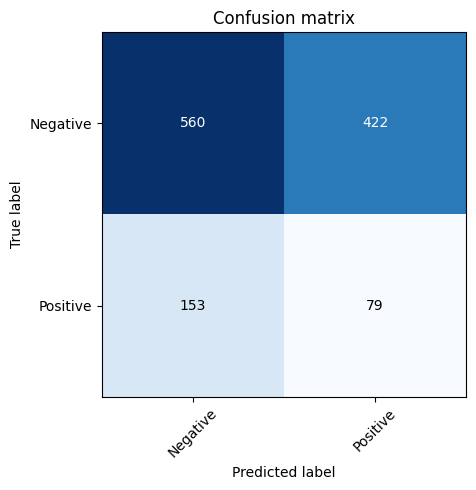

In [16]:

from transformers import AutoConfig
import os
import matplotlib.pyplot as plt
import seaborn as sns
# Disable W&B logging entirely (no login prompt)
os.environ["WANDB_DISABLED"] = "true"

# ---------- Confusion matrix & classification report using pretrained model ----------
print("\n--- Evaluating pretrained model and plotting confusion matrix ---")

# Try to use the model's own num_labels if available; otherwise fallback to our label mapping
config = AutoConfig.from_pretrained(MODEL_NAME)
num_labels_pretrained = getattr(config, "num_labels", None) or NUM_LABELS
print(f"Detected num_labels in pretrained model/config: {num_labels_pretrained}")

# Load pretrained model (no fine-tuning here) and move to device
model_for_eval = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels_pretrained).to(device)

# Create a lightweight Trainer for prediction only
eval_trainer = Trainer(model=model_for_eval, tokenizer=tokenizer)

# Run predictions on the tokenized_eval dataset
preds_output = eval_trainer.predict(tokenized_eval)
preds = np.argmax(preds_output.predictions, axis=1)
labels = preds_output.label_ids

# Compute confusion matrix and classification report
cm = confusion_matrix(labels, preds)
print("\nConfusion matrix (rows=true, cols=predicted):\n", cm)

# If id2label is available, map indices to readable names for the report
target_names = [id2label[i] for i in sorted(id2label.keys())] if id2label else None
print("\nClassification report:\n", classification_report(labels, preds, target_names=target_names))

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.set_title("Confusion matrix")
tick_marks = np.arange(len(target_names) if target_names else cm.shape[0])
ax.set_xticks(tick_marks)
ax.set_yticks(tick_marks)
ax.set_xticklabels(target_names if target_names else [str(i) for i in range(cm.shape[1])], rotation=45)
ax.set_yticklabels(target_names if target_names else [str(i) for i in range(cm.shape[0])])

# annotate cells
fmt = 'd'
thresh = cm.max() / 2.0 if cm.size else 0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')
plt.tight_layout()
plt.show()


# Distillbert

In [18]:
!pip install transformers datasets accelerate optuna scikit-learn matplotlib seaborn -U


In [12]:
import os
import torch
import numpy as np
import pandas as pd
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    set_seed,
)
import optuna
from transformers import TrainerCallback
from google.colab import drive

# ---------------- SET SEED ----------------
set_seed(42)

# ---------------- MOUNT DRIVE ----------------
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:

# ---------------- GPU CHECK ----------------
print("Checking GPU availability...")
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"✓ Using GPU: {torch.cuda.get_device_name(0)}")
    torch.cuda.empty_cache()
else:
    device = torch.device("cpu")
    print("⚠ GPU not available. Using CPU.")


Checking GPU availability...
✓ Using GPU: Tesla T4


In [15]:

# ---------------- Loading and Preprocessing Data ----------------
print("\n--- Loading and Preprocessing Data ---")
csv_path = '/content/drive/MyDrive/datasets/proj dataset/dpwh_finetune2.csv'
df = pd.read_csv(csv_path)

print(f"✓ Loaded dataset with {len(df)} records")
print(f"Columns: {df.columns.tolist()}")
print("\nFirst few rows:")
print(df.head())

# Drop rows that contain "https" in the text (spam)
before_count = len(df)
df = df[~df['text'].str.contains('https', case=False, na=False)].reset_index(drop=True)
dropped = before_count - len(df)
print(f"✓ Dropped {dropped} rows containing 'https' (spam). New dataset size: {len(df)}")

# Check Sentiment distribution and map labels
print("\nSentiment distribution:")
print(df['Sentiment'].value_counts().sort_index())

label2id = {"Negative": 0, "Positive": 1}
id2label = {v: k for k, v in label2id.items()}
df["labels"] = df["Sentiment"].map(label2id)

# Train / Eval split (80/20). Avoid stratify if only one class remains.
stratify_col = df["Sentiment"] if df["Sentiment"].nunique() > 1 else None
if stratify_col is None:
    print("Warning: only one sentiment class present after preprocessing — not stratifying split.")

train_df, eval_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=stratify_col
)

print(f"\n✓ Train set: {len(train_df)} records")
print(f"✓ Eval set: {len(eval_df)} records")

train_data = Dataset.from_pandas(train_df[["text", "labels"]].reset_index(drop=True))
eval_data = Dataset.from_pandas(eval_df[["text", "labels"]].reset_index(drop=True))




--- Loading and Preprocessing Data ---
✓ Loaded dataset with 10262 records
Columns: ['text', 'Sentiment']

First few rows:
                                                text Sentiment
0   Galing mang baliktad ni Marcoleta mantalang n...  Negative
1  Netizens were asking how Escudero was able to ...  Negative
2  Netizens were asking how Escudero was able to ...  Negative
3  The Civil Aviation Authority of the Philippine...  Negative
4  Espinas of Biliran face Plunder Raps over P1B ...  Negative
✓ Dropped 4192 rows containing 'https' (spam). New dataset size: 6070

Sentiment distribution:
Sentiment
Negative    4908
Positive    1162
Name: count, dtype: int64

✓ Train set: 4856 records
✓ Eval set: 1214 records


In [16]:

# ---------------- Tokenizer and Tokenization ----------------
MODEL_NAME = "jcblaise/distilbert-tagalog-base-cased"
print(f"\nLoading tokenizer: {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_function(examples):
    # keep your max_length and padding settings
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

print("Tokenizing training data...")
tokenized_train = train_data.map(tokenize_function, batched=True)
print("Tokenizing evaluation data...")
tokenized_eval = eval_data.map(tokenize_function, batched=True)

tokenized_train.set_format("torch", columns=['input_ids', 'attention_mask', 'labels'])
tokenized_eval.set_format("torch", columns=['input_ids', 'attention_mask', 'labels'])





Loading tokenizer: jcblaise/distilbert-tagalog-base-cased
Tokenizing training data...


Map:   0%|          | 0/4856 [00:00<?, ? examples/s]

Tokenizing evaluation data...


Map:   0%|          | 0/1214 [00:00<?, ? examples/s]

In [17]:
# --- 3. MODEL, METRICS, AND HYPERPARAMETER DEFINITION ---
NUM_LABELS = len(label2id)

def model_init():
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS)
    return model.to(device)

def _extract_pred_labels(preds_raw):
    if isinstance(preds_raw, (list, tuple)):
        logits = None
        for elem in preds_raw:
            if isinstance(elem, np.ndarray):
                logits = elem
                break
        if logits is None:
            try:
                logits = np.asarray(preds_raw)
            except Exception:
                logits = np.array(preds_raw, dtype=object)
    else:
        logits = preds_raw

    if not isinstance(logits, np.ndarray):
        try:
            logits = np.asarray(logits)
        except Exception:
            return np.array([np.argmax(x) if hasattr(x, "__len__") else int(x) for x in logits])

    if logits.ndim == 0:
        return np.array([int(logits)])
    if logits.ndim == 1:
        return logits.astype(int)
    if logits.ndim >= 2:
        if logits.shape[1] == 1:
            probs = 1 / (1 + np.exp(-logits.reshape(-1)))
            return (probs > 0.5).astype(int)
        return np.argmax(logits, axis=1).astype(int)
    return logits.ravel().astype(int)

# Robust compute_metrics for Trainer
def compute_metrics(p):
    pred_labels = _extract_pred_labels(p.predictions)
    true_labels = p.label_ids
    acc = accuracy_score(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels, average="weighted")
    return {"accuracy": acc, "f1": f1}


In [18]:

# --- 4. TRAINING ARGUMENTS (Fixed for all runs) ---
training_args = TrainingArguments(
    output_dir="./random_search_results",
    # Evaluation settings (fixed)
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",  # Optimize for weighted F1-Score
    fp16=torch.cuda.is_available(),
    report_to="none",
    # Fixed parameters
    warmup_steps=500,
)

# Initialize the Trainer
trainer = Trainer(
    model_init=model_init,  # We pass the function, not the object, for fresh initialization
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

# Custom callback to show results after each trial
class OptunaProgressCallback(TrainerCallback):
    """Callback to display trial results after evaluation"""
    def __init__(self):
        self.trial_num = 0

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        if metrics and state.is_world_process_zero:
            print(f"\n📊 Trial Results:")
            print(f" • Eval F1 Score: {metrics.get('eval_f1', 0):.4f}")
            print(f" • Eval Accuracy: {metrics.get('eval_accuracy', 0):.4f}")
            print(f" • Eval Loss: {metrics.get('eval_loss', 0):.4f}")

# Add the callback to trainer
trainer.add_callback(OptunaProgressCallback())



/tmp/ipython-input-2480851252.py:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at jcblaise/distilbert-tagalog-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [40]:

# --- 5. EXECUTION OF RANDOM SEARCH ---
print("\n" + "="*80)
print("STARTING RANDOM SEARCH OPTIMIZATION")
print("="*80)
print("Total Trials: 20")
print("Optimization Metric: Weighted F1-Score")
print("="*80 + "\n")

# Create a custom callback to display hyperparameters for each trial
def optuna_hp_space(trial):
    """Wrapper to display trial information"""
    print(f"\n{'='*80}")
    print(f"TRIAL #{trial.number + 1}")
    print(f"{'='*80}")
    # Get hyperparameters
    hps = tune_hp(trial)
    # Display the hyperparameters being tested
    print("Hyperparameters for this trial:")
    for key, value in hps.items():
        if isinstance(value, float):
            print(f" • {key}: {value:.2e}" if value < 0.001 else f" • {key}: {value:.4f}")
        else:
            print(f" • {key}: {value}")
    print(f"{'='*80}")
    return hps

# Run hyperparameter search (Optuna backend)
best_trial = trainer.hyperparameter_search(
    backend="optuna",
    hp_space=optuna_hp_space,
    direction="maximize",
    n_trials=20,
)

print("\n" + "="*80)
print("RANDOM SEARCH COMPLETE")
print("="*80)

# Extract and print the best configuration
if best_trial:
    print(f"\n✓ Best Trial Found!")
    # optuna integration returns an object: best_trial.objective and best_trial.hyperparameters
    try:
        print(f"✓ Best F1 Score: {best_trial.objective:.4f}")
    except Exception:
        # if the returned object is a dict-like or different structure, just print representation
        print("✓ Best trial summary:", best_trial)
    best_hps = getattr(best_trial, "hyperparameters", best_trial.params if hasattr(best_trial, "params") else None)
    print("\n" + "="*80)
    print("BEST HYPERPARAMETERS")
    print("="*80)
    if best_hps:
        for key, value in best_hps.items():
            if isinstance(value, float):
                print(f" • {key}: {value:.2e}" if value < 0.001 else f" • {key}: {value:.4f}")
            else:
                print(f" • {key}: {value}")
    else:
        print("Could not extract hyperparameters from best_trial object.")
    print("="*80)
    print("\n📊 Performance Summary:")
    try:
        print(f" Final Best F1 Score: {best_trial.objective:.4f}")
    except Exception:
        pass
    print(f" Final Best Accuracy: (Check evaluation results above)")
else:
    print("⚠ Search failed or no best trial found.")

print("\n✓ To use these hyperparameters, create a new TrainingArguments with the best_hps values.")
print("="*80)



[I 2025-11-16 16:01:56,598] A new study created in memory with name: no-name-c4e0d9a4-5799-45cf-a181-b161a4584a8d



STARTING RANDOM SEARCH OPTIMIZATION
Total Trials: 20
Optimization Metric: Weighted F1-Score


TRIAL #1
Hyperparameters for this trial:
 • learning_rate: 1.09e-05
 • per_device_train_batch_size: 16
 • weight_decay: 0.0142
 • num_train_epochs: 3
 • warmup_ratio: 0.0765
 • lr_scheduler_type: constant_with_warmup
 • gradient_accumulation_steps: 4
 • max_grad_norm: 1.0477


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at jcblaise/distilbert-tagalog-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.575587,0.808896,0.723439
2,No log,0.490348,0.808896,0.723439
3,No log,0.476578,0.808896,0.723439



📊 Trial Results:
 • Eval F1 Score: 0.7234
 • Eval Accuracy: 0.8089
 • Eval Loss: 0.5756

📊 Trial Results:
 • Eval F1 Score: 0.7234
 • Eval Accuracy: 0.8089
 • Eval Loss: 0.4903

📊 Trial Results:
 • Eval F1 Score: 0.7234
 • Eval Accuracy: 0.8089
 • Eval Loss: 0.4766


[I 2025-11-16 16:04:13,263] Trial 0 finished with value: 1.532335262856234 and parameters: {'learning_rate': 1.0893143586416813e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.014246715208673988, 'num_train_epochs': 3, 'warmup_ratio': 0.07654758014628078, 'lr_scheduler_type': 'constant_with_warmup', 'gradient_accumulation_steps': 4, 'max_grad_norm': 1.0477263951819937}. Best is trial 0 with value: 1.532335262856234.



TRIAL #2
Hyperparameters for this trial:
 • learning_rate: 1.03e-05
 • per_device_train_batch_size: 8
 • weight_decay: 0.0573
 • num_train_epochs: 3
 • warmup_ratio: 0.0592
 • lr_scheduler_type: constant_with_warmup
 • gradient_accumulation_steps: 4
 • max_grad_norm: 1.7666


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at jcblaise/distilbert-tagalog-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.496842,0.808896,0.723439
2,No log,0.474128,0.808896,0.723439
3,No log,0.448903,0.815486,0.754121



📊 Trial Results:
 • Eval F1 Score: 0.7234
 • Eval Accuracy: 0.8089
 • Eval Loss: 0.4968

📊 Trial Results:
 • Eval F1 Score: 0.7234
 • Eval Accuracy: 0.8089
 • Eval Loss: 0.4741

📊 Trial Results:
 • Eval F1 Score: 0.7541
 • Eval Accuracy: 0.8155
 • Eval Loss: 0.4489


[I 2025-11-16 16:07:08,552] Trial 1 finished with value: 1.5696068506015308 and parameters: {'learning_rate': 1.0340495922219696e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.05731073350236174, 'num_train_epochs': 3, 'warmup_ratio': 0.05920528609176075, 'lr_scheduler_type': 'constant_with_warmup', 'gradient_accumulation_steps': 4, 'max_grad_norm': 1.7666182527876306}. Best is trial 1 with value: 1.5696068506015308.



TRIAL #3
Hyperparameters for this trial:
 • learning_rate: 5.40e-06
 • per_device_train_batch_size: 8
 • weight_decay: 0.0216
 • num_train_epochs: 4
 • warmup_ratio: 0.1404
 • lr_scheduler_type: constant_with_warmup
 • gradient_accumulation_steps: 4
 • max_grad_norm: 1.2128


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at jcblaise/distilbert-tagalog-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.529720,0.808896,0.723439
2,No log,0.481817,0.808896,0.723439
3,No log,0.470904,0.808896,0.723439
4,0.521000,0.456382,0.814662,0.754736



📊 Trial Results:
 • Eval F1 Score: 0.7234
 • Eval Accuracy: 0.8089
 • Eval Loss: 0.5297

📊 Trial Results:
 • Eval F1 Score: 0.7234
 • Eval Accuracy: 0.8089
 • Eval Loss: 0.4818

📊 Trial Results:
 • Eval F1 Score: 0.7234
 • Eval Accuracy: 0.8089
 • Eval Loss: 0.4709

📊 Trial Results:
 • Eval F1 Score: 0.7547
 • Eval Accuracy: 0.8147
 • Eval Loss: 0.4564


[I 2025-11-16 16:10:35,661] Trial 2 finished with value: 1.5693987238009743 and parameters: {'learning_rate': 5.404455471370374e-06, 'per_device_train_batch_size': 8, 'weight_decay': 0.021605414202094587, 'num_train_epochs': 4, 'warmup_ratio': 0.14037981567536925, 'lr_scheduler_type': 'constant_with_warmup', 'gradient_accumulation_steps': 4, 'max_grad_norm': 1.2127885281447253}. Best is trial 1 with value: 1.5696068506015308.



TRIAL #4
Hyperparameters for this trial:
 • learning_rate: 8.48e-06
 • per_device_train_batch_size: 16
 • weight_decay: 0.0531
 • num_train_epochs: 4
 • warmup_ratio: 0.1239
 • lr_scheduler_type: cosine
 • gradient_accumulation_steps: 1
 • max_grad_norm: 0.7220


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at jcblaise/distilbert-tagalog-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.480046,0.808896,0.723439
2,0.519100,0.456343,0.809720,0.734221
3,0.519100,0.442861,0.818781,0.763942
4,0.422400,0.443313,0.820428,0.769117



📊 Trial Results:
 • Eval F1 Score: 0.7234
 • Eval Accuracy: 0.8089
 • Eval Loss: 0.4800

📊 Trial Results:
 • Eval F1 Score: 0.7342
 • Eval Accuracy: 0.8097
 • Eval Loss: 0.4563

📊 Trial Results:
 • Eval F1 Score: 0.7639
 • Eval Accuracy: 0.8188
 • Eval Loss: 0.4429

📊 Trial Results:
 • Eval F1 Score: 0.7691
 • Eval Accuracy: 0.8204
 • Eval Loss: 0.4433


[I 2025-11-16 16:14:32,898] Trial 3 finished with value: 1.5895457053538284 and parameters: {'learning_rate': 8.48472135902026e-06, 'per_device_train_batch_size': 16, 'weight_decay': 0.05310504537173497, 'num_train_epochs': 4, 'warmup_ratio': 0.12393714319070276, 'lr_scheduler_type': 'cosine', 'gradient_accumulation_steps': 1, 'max_grad_norm': 0.7219577490646236}. Best is trial 3 with value: 1.5895457053538284.



TRIAL #5
Hyperparameters for this trial:
 • learning_rate: 1.08e-05
 • per_device_train_batch_size: 16
 • weight_decay: 0.0899
 • num_train_epochs: 3
 • warmup_ratio: 0.0818
 • lr_scheduler_type: linear
 • gradient_accumulation_steps: 1
 • max_grad_norm: 1.6035


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at jcblaise/distilbert-tagalog-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.477011,0.808896,0.723439
2,0.512200,0.453425,0.815486,0.754121
3,0.512200,0.440120,0.821252,0.771632



📊 Trial Results:
 • Eval F1 Score: 0.7234
 • Eval Accuracy: 0.8089
 • Eval Loss: 0.4770

📊 Trial Results:
 • Eval F1 Score: 0.7541
 • Eval Accuracy: 0.8155
 • Eval Loss: 0.4534

📊 Trial Results:
 • Eval F1 Score: 0.7716
 • Eval Accuracy: 0.8213
 • Eval Loss: 0.4401


[I 2025-11-16 16:17:22,937] Trial 4 finished with value: 1.5928842544667345 and parameters: {'learning_rate': 1.0790936515592454e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.08988657734817104, 'num_train_epochs': 3, 'warmup_ratio': 0.08179691203294093, 'lr_scheduler_type': 'linear', 'gradient_accumulation_steps': 1, 'max_grad_norm': 1.603464791581058}. Best is trial 4 with value: 1.5928842544667345.



TRIAL #6
Hyperparameters for this trial:
 • learning_rate: 3.15e-05
 • per_device_train_batch_size: 32
 • weight_decay: 0.0258
 • num_train_epochs: 3
 • warmup_ratio: 0.0733
 • lr_scheduler_type: cosine
 • gradient_accumulation_steps: 4
 • max_grad_norm: 1.9862


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at jcblaise/distilbert-tagalog-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.595262,0.808896,0.723439
2,No log,0.499390,0.808896,0.723439
3,No log,0.483472,0.808896,0.723439



📊 Trial Results:
 • Eval F1 Score: 0.7234
 • Eval Accuracy: 0.8089
 • Eval Loss: 0.5953

📊 Trial Results:
 • Eval F1 Score: 0.7234
 • Eval Accuracy: 0.8089
 • Eval Loss: 0.4994

📊 Trial Results:
 • Eval F1 Score: 0.7234
 • Eval Accuracy: 0.8089
 • Eval Loss: 0.4835


[I 2025-11-16 16:19:53,418] Trial 5 finished with value: 1.532335262856234 and parameters: {'learning_rate': 3.151997086368401e-05, 'per_device_train_batch_size': 32, 'weight_decay': 0.025813977943280476, 'num_train_epochs': 3, 'warmup_ratio': 0.07331145559144599, 'lr_scheduler_type': 'cosine', 'gradient_accumulation_steps': 4, 'max_grad_norm': 1.986206345413244}. Best is trial 4 with value: 1.5928842544667345.



TRIAL #7
Hyperparameters for this trial:
 • learning_rate: 8.24e-06
 • per_device_train_batch_size: 16
 • weight_decay: 0.0948
 • num_train_epochs: 4
 • warmup_ratio: 0.1471
 • lr_scheduler_type: constant_with_warmup
 • gradient_accumulation_steps: 1
 • max_grad_norm: 1.8296


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at jcblaise/distilbert-tagalog-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.481198,0.808896,0.723439
2,0.519900,0.456844,0.808896,0.735141



📊 Trial Results:
 • Eval F1 Score: 0.7234
 • Eval Accuracy: 0.8089
 • Eval Loss: 0.4812

📊 Trial Results:
 • Eval F1 Score: 0.7351
 • Eval Accuracy: 0.8089
 • Eval Loss: 0.4568


[I 2025-11-16 16:21:16,451] Trial 6 pruned. 



TRIAL #8
Hyperparameters for this trial:
 • learning_rate: 3.94e-05
 • per_device_train_batch_size: 8
 • weight_decay: 0.0727
 • num_train_epochs: 4
 • warmup_ratio: 0.0863
 • lr_scheduler_type: constant_with_warmup
 • gradient_accumulation_steps: 1
 • max_grad_norm: 1.0684


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at jcblaise/distilbert-tagalog-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.494100,0.454199,0.822900,0.768795
2,0.422000,0.500061,0.838550,0.804318
3,0.312500,0.520538,0.838550,0.833865
4,0.212500,0.809704,0.843493,0.839870



📊 Trial Results:
 • Eval F1 Score: 0.7688
 • Eval Accuracy: 0.8229
 • Eval Loss: 0.4542

📊 Trial Results:
 • Eval F1 Score: 0.8043
 • Eval Accuracy: 0.8386
 • Eval Loss: 0.5001

📊 Trial Results:
 • Eval F1 Score: 0.8339
 • Eval Accuracy: 0.8386
 • Eval Loss: 0.5205

📊 Trial Results:
 • Eval F1 Score: 0.8399
 • Eval Accuracy: 0.8435
 • Eval Loss: 0.8097


[I 2025-11-16 16:25:41,368] Trial 7 finished with value: 1.6833623860162752 and parameters: {'learning_rate': 3.9449267407997656e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.07273370559989976, 'num_train_epochs': 4, 'warmup_ratio': 0.08633172195588326, 'lr_scheduler_type': 'constant_with_warmup', 'gradient_accumulation_steps': 1, 'max_grad_norm': 1.068359005566507}. Best is trial 7 with value: 1.6833623860162752.



TRIAL #9
Hyperparameters for this trial:
 • learning_rate: 1.61e-05
 • per_device_train_batch_size: 8
 • weight_decay: 0.0787
 • num_train_epochs: 3
 • warmup_ratio: 0.0097
 • lr_scheduler_type: linear
 • gradient_accumulation_steps: 4
 • max_grad_norm: 0.5053


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at jcblaise/distilbert-tagalog-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.486197,0.808896,0.723439
2,No log,0.463751,0.808896,0.723439
3,No log,0.436498,0.819605,0.768552



📊 Trial Results:
 • Eval F1 Score: 0.7234
 • Eval Accuracy: 0.8089
 • Eval Loss: 0.4862

📊 Trial Results:
 • Eval F1 Score: 0.7234
 • Eval Accuracy: 0.8089
 • Eval Loss: 0.4638

📊 Trial Results:
 • Eval F1 Score: 0.7686
 • Eval Accuracy: 0.8196
 • Eval Loss: 0.4365


[I 2025-11-16 16:28:50,346] Trial 8 finished with value: 1.5881563985216474 and parameters: {'learning_rate': 1.6074637889221725e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.0787087831214538, 'num_train_epochs': 3, 'warmup_ratio': 0.009694867233055394, 'lr_scheduler_type': 'linear', 'gradient_accumulation_steps': 4, 'max_grad_norm': 0.5052676671260783}. Best is trial 7 with value: 1.6833623860162752.



TRIAL #10
Hyperparameters for this trial:
 • learning_rate: 1.14e-05
 • per_device_train_batch_size: 8
 • weight_decay: 1.79e-04
 • num_train_epochs: 3
 • warmup_ratio: 0.0620
 • lr_scheduler_type: cosine
 • gradient_accumulation_steps: 1
 • max_grad_norm: 0.6473


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at jcblaise/distilbert-tagalog-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.521200,0.450275,0.808896,0.735141



📊 Trial Results:
 • Eval F1 Score: 0.7351
 • Eval Accuracy: 0.8089
 • Eval Loss: 0.4503


[I 2025-11-16 16:29:31,380] Trial 9 pruned. 



TRIAL #11
Hyperparameters for this trial:
 • learning_rate: 3.80e-05
 • per_device_train_batch_size: 32
 • weight_decay: 0.0687
 • num_train_epochs: 4
 • warmup_ratio: 0.0132
 • lr_scheduler_type: constant_with_warmup
 • gradient_accumulation_steps: 2
 • max_grad_norm: 0.9175


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at jcblaise/distilbert-tagalog-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.493042,0.808896,0.723439
2,No log,0.469680,0.808896,0.723439
3,No log,0.451246,0.817133,0.757448
4,No log,0.439173,0.819605,0.803613



📊 Trial Results:
 • Eval F1 Score: 0.7234
 • Eval Accuracy: 0.8089
 • Eval Loss: 0.4930

📊 Trial Results:
 • Eval F1 Score: 0.7234
 • Eval Accuracy: 0.8089
 • Eval Loss: 0.4697

📊 Trial Results:
 • Eval F1 Score: 0.7574
 • Eval Accuracy: 0.8171
 • Eval Loss: 0.4512

📊 Trial Results:
 • Eval F1 Score: 0.8036
 • Eval Accuracy: 0.8196
 • Eval Loss: 0.4392


[I 2025-11-16 16:32:52,635] Trial 10 finished with value: 1.623217118087131 and parameters: {'learning_rate': 3.80203616010394e-05, 'per_device_train_batch_size': 32, 'weight_decay': 0.06865836982439893, 'num_train_epochs': 4, 'warmup_ratio': 0.01319655390666677, 'lr_scheduler_type': 'constant_with_warmup', 'gradient_accumulation_steps': 2, 'max_grad_norm': 0.91748077477385}. Best is trial 7 with value: 1.6833623860162752.



TRIAL #12
Hyperparameters for this trial:
 • learning_rate: 4.77e-05
 • per_device_train_batch_size: 32
 • weight_decay: 0.0713
 • num_train_epochs: 4
 • warmup_ratio: 0.1833
 • lr_scheduler_type: constant_with_warmup
 • gradient_accumulation_steps: 2
 • max_grad_norm: 0.9397


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at jcblaise/distilbert-tagalog-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.490353,0.808896,0.723439
2,No log,0.462946,0.808896,0.723439
3,No log,0.436446,0.820428,0.765046
4,No log,0.440497,0.817133,0.806265



📊 Trial Results:
 • Eval F1 Score: 0.7234
 • Eval Accuracy: 0.8089
 • Eval Loss: 0.4904

📊 Trial Results:
 • Eval F1 Score: 0.7234
 • Eval Accuracy: 0.8089
 • Eval Loss: 0.4629

📊 Trial Results:
 • Eval F1 Score: 0.7650
 • Eval Accuracy: 0.8204
 • Eval Loss: 0.4364

📊 Trial Results:
 • Eval F1 Score: 0.8063
 • Eval Accuracy: 0.8171
 • Eval Loss: 0.4405


[I 2025-11-16 16:36:32,154] Trial 11 finished with value: 1.6233981592414666 and parameters: {'learning_rate': 4.7651097450572156e-05, 'per_device_train_batch_size': 32, 'weight_decay': 0.07132955544379885, 'num_train_epochs': 4, 'warmup_ratio': 0.18326774399964557, 'lr_scheduler_type': 'constant_with_warmup', 'gradient_accumulation_steps': 2, 'max_grad_norm': 0.9396626962363954}. Best is trial 7 with value: 1.6833623860162752.



TRIAL #13
Hyperparameters for this trial:
 • learning_rate: 4.95e-05
 • per_device_train_batch_size: 32
 • weight_decay: 0.0745
 • num_train_epochs: 4
 • warmup_ratio: 0.1835
 • lr_scheduler_type: constant_with_warmup
 • gradient_accumulation_steps: 2
 • max_grad_norm: 1.3868


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at jcblaise/distilbert-tagalog-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.491078,0.808896,0.723439
2,No log,0.464938,0.808896,0.723439
3,No log,0.435331,0.818781,0.763942
4,No log,0.440366,0.817957,0.807777



📊 Trial Results:
 • Eval F1 Score: 0.7234
 • Eval Accuracy: 0.8089
 • Eval Loss: 0.4911

📊 Trial Results:
 • Eval F1 Score: 0.7234
 • Eval Accuracy: 0.8089
 • Eval Loss: 0.4649

📊 Trial Results:
 • Eval F1 Score: 0.7639
 • Eval Accuracy: 0.8188
 • Eval Loss: 0.4353

📊 Trial Results:
 • Eval F1 Score: 0.8078
 • Eval Accuracy: 0.8180
 • Eval Loss: 0.4404


[I 2025-11-16 16:39:56,706] Trial 12 finished with value: 1.6257340168835368 and parameters: {'learning_rate': 4.954383150902654e-05, 'per_device_train_batch_size': 32, 'weight_decay': 0.07449105018913335, 'num_train_epochs': 4, 'warmup_ratio': 0.1834762375750495, 'lr_scheduler_type': 'constant_with_warmup', 'gradient_accumulation_steps': 2, 'max_grad_norm': 1.3868050121535853}. Best is trial 7 with value: 1.6833623860162752.



TRIAL #14
Hyperparameters for this trial:
 • learning_rate: 2.35e-05
 • per_device_train_batch_size: 32
 • weight_decay: 0.0395
 • num_train_epochs: 4
 • warmup_ratio: 0.1991
 • lr_scheduler_type: constant_with_warmup
 • gradient_accumulation_steps: 2
 • max_grad_norm: 1.4305


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at jcblaise/distilbert-tagalog-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.514688,0.808896,0.723439
2,No log,0.478572,0.808896,0.723439
3,No log,0.465589,0.808896,0.723439



📊 Trial Results:
 • Eval F1 Score: 0.7234
 • Eval Accuracy: 0.8089
 • Eval Loss: 0.5147

📊 Trial Results:
 • Eval F1 Score: 0.7234
 • Eval Accuracy: 0.8089
 • Eval Loss: 0.4786

📊 Trial Results:
 • Eval F1 Score: 0.7234
 • Eval Accuracy: 0.8089
 • Eval Loss: 0.4656


[I 2025-11-16 16:42:11,285] Trial 13 pruned. 



TRIAL #15
Hyperparameters for this trial:
 • learning_rate: 2.58e-05
 • per_device_train_batch_size: 8
 • weight_decay: 0.0797
 • num_train_epochs: 4
 • warmup_ratio: 0.1188
 • lr_scheduler_type: constant_with_warmup
 • gradient_accumulation_steps: 2
 • max_grad_norm: 1.3223


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at jcblaise/distilbert-tagalog-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.457965,0.808896,0.723439
2,0.489000,0.440510,0.819605,0.767561
3,0.489000,0.412219,0.844316,0.834879
4,0.330500,0.593935,0.808896,0.815223



📊 Trial Results:
 • Eval F1 Score: 0.7234
 • Eval Accuracy: 0.8089
 • Eval Loss: 0.4580

📊 Trial Results:
 • Eval F1 Score: 0.7676
 • Eval Accuracy: 0.8196
 • Eval Loss: 0.4405

📊 Trial Results:
 • Eval F1 Score: 0.8349
 • Eval Accuracy: 0.8443
 • Eval Loss: 0.4122

📊 Trial Results:
 • Eval F1 Score: 0.8152
 • Eval Accuracy: 0.8089
 • Eval Loss: 0.5939


[I 2025-11-16 16:46:09,093] Trial 14 finished with value: 1.6241191766452732 and parameters: {'learning_rate': 2.5750532979679423e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.07967059648573578, 'num_train_epochs': 4, 'warmup_ratio': 0.11880415215716611, 'lr_scheduler_type': 'constant_with_warmup', 'gradient_accumulation_steps': 2, 'max_grad_norm': 1.322292627652604}. Best is trial 7 with value: 1.6833623860162752.



TRIAL #16
Hyperparameters for this trial:
 • learning_rate: 4.87e-05
 • per_device_train_batch_size: 32
 • weight_decay: 0.0606
 • num_train_epochs: 4
 • warmup_ratio: 0.1636
 • lr_scheduler_type: linear
 • gradient_accumulation_steps: 1
 • max_grad_norm: 1.1339


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at jcblaise/distilbert-tagalog-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.471573,0.808896,0.723439
2,No log,0.458220,0.819605,0.763438
3,No log,0.413554,0.834432,0.818373
4,0.429400,0.474445,0.824547,0.822905



📊 Trial Results:
 • Eval F1 Score: 0.7234
 • Eval Accuracy: 0.8089
 • Eval Loss: 0.4716

📊 Trial Results:
 • Eval F1 Score: 0.7634
 • Eval Accuracy: 0.8196
 • Eval Loss: 0.4582

📊 Trial Results:
 • Eval F1 Score: 0.8184
 • Eval Accuracy: 0.8344
 • Eval Loss: 0.4136

📊 Trial Results:
 • Eval F1 Score: 0.8229
 • Eval Accuracy: 0.8245
 • Eval Loss: 0.4744


[I 2025-11-16 16:49:41,365] Trial 15 finished with value: 1.6474522832304204 and parameters: {'learning_rate': 4.872317016205055e-05, 'per_device_train_batch_size': 32, 'weight_decay': 0.06064486791662172, 'num_train_epochs': 4, 'warmup_ratio': 0.16358453510780158, 'lr_scheduler_type': 'linear', 'gradient_accumulation_steps': 1, 'max_grad_norm': 1.133897451307976}. Best is trial 7 with value: 1.6833623860162752.



TRIAL #17
Hyperparameters for this trial:
 • learning_rate: 1.87e-05
 • per_device_train_batch_size: 8
 • weight_decay: 0.0391
 • num_train_epochs: 4
 • warmup_ratio: 0.0405
 • lr_scheduler_type: linear
 • gradient_accumulation_steps: 1
 • max_grad_norm: 1.1191


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at jcblaise/distilbert-tagalog-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.509400,0.442008,0.817957,0.759097



📊 Trial Results:
 • Eval F1 Score: 0.7591
 • Eval Accuracy: 0.8180
 • Eval Loss: 0.4420


[I 2025-11-16 16:50:21,765] Trial 16 pruned. 



TRIAL #18
Hyperparameters for this trial:
 • learning_rate: 3.48e-05
 • per_device_train_batch_size: 32
 • weight_decay: 0.0628
 • num_train_epochs: 4
 • warmup_ratio: 0.1030
 • lr_scheduler_type: linear
 • gradient_accumulation_steps: 1
 • max_grad_norm: 0.7573


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at jcblaise/distilbert-tagalog-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.474778,0.808896,0.723439
2,No log,0.457474,0.814662,0.752443
3,No log,0.428931,0.817133,0.804493
4,0.450400,0.436700,0.824547,0.821642



📊 Trial Results:
 • Eval F1 Score: 0.7234
 • Eval Accuracy: 0.8089
 • Eval Loss: 0.4748

📊 Trial Results:
 • Eval F1 Score: 0.7524
 • Eval Accuracy: 0.8147
 • Eval Loss: 0.4575

📊 Trial Results:
 • Eval F1 Score: 0.8045
 • Eval Accuracy: 0.8171
 • Eval Loss: 0.4289

📊 Trial Results:
 • Eval F1 Score: 0.8216
 • Eval Accuracy: 0.8245
 • Eval Loss: 0.4367


[I 2025-11-16 16:53:42,209] Trial 17 finished with value: 1.6461888242087062 and parameters: {'learning_rate': 3.482124243896377e-05, 'per_device_train_batch_size': 32, 'weight_decay': 0.06275204049552391, 'num_train_epochs': 4, 'warmup_ratio': 0.10302548275059434, 'lr_scheduler_type': 'linear', 'gradient_accumulation_steps': 1, 'max_grad_norm': 0.7573294908119996}. Best is trial 7 with value: 1.6833623860162752.



TRIAL #19
Hyperparameters for this trial:
 • learning_rate: 2.35e-05
 • per_device_train_batch_size: 32
 • weight_decay: 0.0442
 • num_train_epochs: 4
 • warmup_ratio: 0.1632
 • lr_scheduler_type: linear
 • gradient_accumulation_steps: 1
 • max_grad_norm: 1.5007


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at jcblaise/distilbert-tagalog-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.482178,0.808896,0.723439
2,No log,0.458499,0.809720,0.734221
3,No log,0.427580,0.831960,0.793293
4,0.467600,0.431009,0.828666,0.817662



📊 Trial Results:
 • Eval F1 Score: 0.7234
 • Eval Accuracy: 0.8089
 • Eval Loss: 0.4822

📊 Trial Results:
 • Eval F1 Score: 0.7342
 • Eval Accuracy: 0.8097
 • Eval Loss: 0.4585

📊 Trial Results:
 • Eval F1 Score: 0.7933
 • Eval Accuracy: 0.8320
 • Eval Loss: 0.4276

📊 Trial Results:
 • Eval F1 Score: 0.8177
 • Eval Accuracy: 0.8287
 • Eval Loss: 0.4310


[I 2025-11-16 16:57:07,061] Trial 18 finished with value: 1.646327884087357 and parameters: {'learning_rate': 2.3529597714075396e-05, 'per_device_train_batch_size': 32, 'weight_decay': 0.04420758756662174, 'num_train_epochs': 4, 'warmup_ratio': 0.16321695516365595, 'lr_scheduler_type': 'linear', 'gradient_accumulation_steps': 1, 'max_grad_norm': 1.500725766217522}. Best is trial 7 with value: 1.6833623860162752.



TRIAL #20
Hyperparameters for this trial:
 • learning_rate: 4.23e-05
 • per_device_train_batch_size: 8
 • weight_decay: 0.0876
 • num_train_epochs: 4
 • warmup_ratio: 0.1028
 • lr_scheduler_type: linear
 • gradient_accumulation_steps: 1
 • max_grad_norm: 0.9368


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at jcblaise/distilbert-tagalog-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.493400,0.461881,0.822900,0.768795
2,0.415400,0.434352,0.844316,0.817976
3,0.304600,0.552748,0.850906,0.842220
4,0.188300,0.771432,0.844316,0.834879



📊 Trial Results:
 • Eval F1 Score: 0.7688
 • Eval Accuracy: 0.8229
 • Eval Loss: 0.4619

📊 Trial Results:
 • Eval F1 Score: 0.8180
 • Eval Accuracy: 0.8443
 • Eval Loss: 0.4344

📊 Trial Results:
 • Eval F1 Score: 0.8422
 • Eval Accuracy: 0.8509
 • Eval Loss: 0.5527

📊 Trial Results:
 • Eval F1 Score: 0.8349
 • Eval Accuracy: 0.8443
 • Eval Loss: 0.7714


[I 2025-11-16 17:01:14,064] Trial 19 finished with value: 1.679194972358601 and parameters: {'learning_rate': 4.228628529521985e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.08759003189242523, 'num_train_epochs': 4, 'warmup_ratio': 0.10277774753105688, 'lr_scheduler_type': 'linear', 'gradient_accumulation_steps': 1, 'max_grad_norm': 0.9368139709735888}. Best is trial 7 with value: 1.6833623860162752.



RANDOM SEARCH COMPLETE

✓ Best Trial Found!
✓ Best F1 Score: 1.6834

BEST HYPERPARAMETERS
 • learning_rate: 3.94e-05
 • per_device_train_batch_size: 8
 • weight_decay: 0.0727
 • num_train_epochs: 4
 • warmup_ratio: 0.0863
 • lr_scheduler_type: constant_with_warmup
 • gradient_accumulation_steps: 1
 • max_grad_norm: 1.0684

📊 Performance Summary:
 Final Best F1 Score: 1.6834
 Final Best Accuracy: (Check evaluation results above)

✓ To use these hyperparameters, create a new TrainingArguments with the best_hps values.



Classification Report:

              precision    recall  f1-score   support

    Negative     0.8073    0.9898    0.8893       982
    Positive     0.0000    0.0000    0.0000       232

    accuracy                         0.8007      1214
   macro avg     0.4037    0.4949    0.4446      1214
weighted avg     0.6530    0.8007    0.7193      1214


Confusion Matrix (counts):


,Negative,Positive
Negative,972,10
Positive,232,0



Confusion Matrix (normalized by true label / recall):


,Negative,Positive
Negative,0.9898,0.0102
Positive,1.0000,0.0000


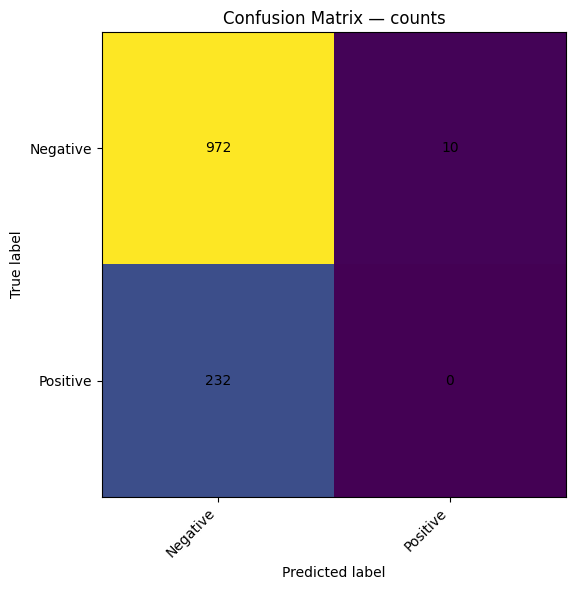

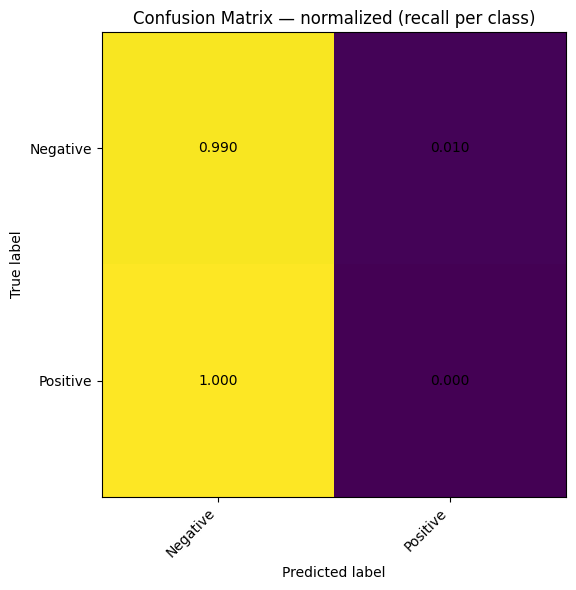


Saved normalized confusion matrix to ./confusion_matrix_normalized.png


<Figure size 640x480 with 0 Axes>

In [19]:
# ---------------- CONFUSION MATRIX & CLASSIFICATION REPORT ----------------
# Paste this block below your existing Colab code (in a new cell)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

# 1) Run prediction on the eval dataset
pred_output = trainer.predict(tokenized_eval)  # returns PredictionOutput(predictions, label_ids, metrics)

# 2) Extract predicted labels robustly using your helper
pred_labels = _extract_pred_labels(pred_output.predictions)
true_labels = pred_output.label_ids

# safety check shapes
assert len(pred_labels) == len(true_labels), "Prediction / label length mismatch"

# 3) Build confusion matrix
# use sorted label ids so row/cols order is consistent
label_ids_sorted = sorted(id2label.keys())
label_names = [id2label[i] for i in label_ids_sorted]

cm = confusion_matrix(true_labels, pred_labels, labels=label_ids_sorted)

# 4) Normalized confusion matrix (row-wise: recall per class)
with np.errstate(all="ignore"):
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
cm_norm = np.nan_to_num(cm_norm)  # convert NaN (from zero-rows) to 0

# 5) Print classification report (uses label names)
print("\nClassification Report:\n")
print(classification_report(true_labels, pred_labels, target_names=label_names, digits=4))

# 6) Show confusion matrix as DataFrame for easy viewing
cm_df = pd.DataFrame(cm, index=label_names, columns=label_names)
print("\nConfusion Matrix (counts):")
display(cm_df)

cm_norm_df = pd.DataFrame(np.round(cm_norm, 4), index=label_names, columns=label_names)
print("\nConfusion Matrix (normalized by true label / recall):")
display(cm_norm_df)

# 7) Plot confusion matrices (counts and normalized)
def plot_cm(matrix, labels, title="Confusion matrix", annotate=True, fmt="{:d}"):
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(matrix, aspect='equal')
    ax.set_title(title)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_yticklabels(labels)
    # annotate
    if annotate:
        for i in range(matrix.shape[0]):
            for j in range(matrix.shape[1]):
                val = matrix[i, j]
                if isinstance(val, float):
                    s = f"{val:.3f}"
                else:
                    s = fmt.format(int(val))
                ax.text(j, i, s, ha="center", va="center", fontsize=10)
    fig.tight_layout()
    return fig, ax

# plot counts
plot_cm(cm, label_names, title="Confusion Matrix — counts", annotate=True, fmt="{:d}")
plt.show()

# plot normalized
plot_cm(cm_norm, label_names, title="Confusion Matrix — normalized (recall per class)", annotate=True, fmt="{:.3f}")
plt.show()

# 8) (Optional) Save figures
plt.savefig("confusion_matrix_normalized.png", bbox_inches="tight")
print("\nSaved normalized confusion matrix to ./confusion_matrix_normalized.png")
